In [1]:
from sotodlib import core, io

import datetime as dt

import numpy as np
import dill as pk

import h5py
from optical_loading import pwv_interp
import map_utils as mu 

import astropy.units as u
from astropy.time import Time


%load_ext autoreload
%autoreload 2

/so/home/jorlo/venvs/sotodlib/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open("wafer_net_c.pk", "rb") as f:
    wafer_net_c = pk.load(f)

In [3]:
with open("results_12012025.pk", "rb") as f:
    result_dict = pk.load(f)
    
with open("abscals.pk", "rb") as f:
    abscal_dict = pk.load(f)


# Plotting

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sotodlib import core, io

import datetime as dt

import numpy as np
import dill as pk

import h5py
from optical_loading import pwv_interp

pwv = pwv_interp()
with open("results_12012025.pk", "rb") as f:
    result_dict = pk.load(f)
    
#with open("backups/backup_nets.pk", "rb") as f:
with open("nets.pk", "rb") as f:
    net_dict = pk.load(f)
    
c_base = (220/255, 50/255, 32/255)
c_goal = (0/255, 90/255, 181/255)

#Problem with abscals in net_dict
#net_dict["mv20"]["150"]["raw_cal"] = [8.950558050822046] * len(net_dict["mv20"]["150"]["obs"])
#net_dict["mv20"]["090"]["raw_cal"] = [14.341169689744175] * len(net_dict["mv20"]["090"]["obs"])

In [12]:
labels = []
nets = []
obs = []
pwvs = []
ndets = []
neps = []
neis = []
cals = []
els = []
yields = []
t_obs = []
indv_nets = []
array_freqs = []
arrays = []

freqs = ["090", "150", "220", "280"]
ufms = sorted(result_dict.keys())

units = "\mu K_{RJ}"

for freq in freqs: #This is slighly inefficient but the ezest way to sort by freq then ufm
    if freq in ["090", "150"]:
        flavor = "MF"
        if freq == "090":
            ch = "MF_1"
        else:
            ch = "MF_2"
    elif freq in ["220", "280"]:
        flavor = "UHF"
        if freq == "220":
            ch = "UHF_1"
        else:
            ch = "UHF_2"
    if units == "\mu K_{CMB}":        
        temp_conv = mu.temp_conv(T_B=2.725*u.Kelvin, flavor=flavor, ch=ch, kind='baseline')
    else:
        temp_conv = 1
    for ufm in ufms:
        for key in net_dict.keys():
            if ufm not in key:
                continue
            for sub_key in net_dict[key].keys():
                if freq not in sub_key:
                    continue
                cur_nets = np.array(net_dict[key][sub_key]["nets"])
                cur_obs = np.array(net_dict[key][sub_key]["obs"])
                cur_ndets = np.array(net_dict[key][sub_key]["ndets"])
                cur_abscals = np.array(net_dict[key][sub_key]["raw_cal"])
                correct_abscals = np.array(np.mean(result_dict[key][sub_key]["raw_cal"]))
                cur_neis =net_dict[key][sub_key]["neps"]
                cur_el = np.array(net_dict[key][sub_key]["el"])

                label = str(freq)+"_"+str(ufm)
                for j in range(len(cur_nets)):
                    cur_time = cur_obs[j].split("_")[1]
                    cur_pwv = pwv(cur_time)
                    if cur_nets[j] <= 100 and cur_ndets[j] > 100: #very large nets are not real
                        nets.append(cur_nets[j]*temp_conv)# * correct_abscals / cur_abscals[j])
                        labels.append(label)
                        obs.append(cur_obs[j])
                        pwvs.append(cur_pwv)
                        ndets.append(cur_ndets[j])
                        neps.append(cur_nets[j]/cur_abscals[j]*np.sqrt(2)*np.sqrt(cur_ndets[j]))
                        indv_nets.append(cur_nets[j]*np.sqrt(cur_ndets[j]))
                        cals.append(cur_abscals[j])
                        els.append(cur_el[j])
                        yields.append(cur_ndets[j]/860)
                        t_obs.append(float(cur_time))
                        arrays.append(ufm)
                        array_freqs.append(freq)
                        for nei in cur_neis[j]:
                            neis.append(nei)
                    
labels = np.array(labels)
nets = np.array(nets)
obs = np.array(obs)
pwvs = np.array(pwvs)
ndets = np.array(ndets)
neps = np.array(neps)
neis = np.array(neis)
cals = np.array(cals)
els = np.array(els)
yields = np.array(yields)
t_obs= np.array(t_obs)
indv_nets = np.array(indv_nets)
arrays = np.array(arrays)
array_freqs = np.array(array_freqs)

df = pd.DataFrame({'labels': labels, 'nets': nets, 'obs': obs, "ndets":ndets, "pwv":pwvs, "neps":neps, "cals":cals, "el":els, "yields":yields, "t_obs":t_obs, "indv_nets":indv_nets, "ufms":arrays, "freqs":array_freqs})

In [24]:
cur_obs[j]

np.str_('obs_1749352764_lati5_111')

In [25]:
cur_time

'1749352764'

In [21]:
(t_cut_low.unix < df.t_obs)

0        False
1        False
2        False
3        False
4        False
         ...  
16280    False
16281    False
16282    False
16283    False
16284    False
Name: t_obs, Length: 16285, dtype: bool

In [26]:
t_cut_low.unix

np.float64(1757030400.0)

ValueError: cannot convert float NaN to integer

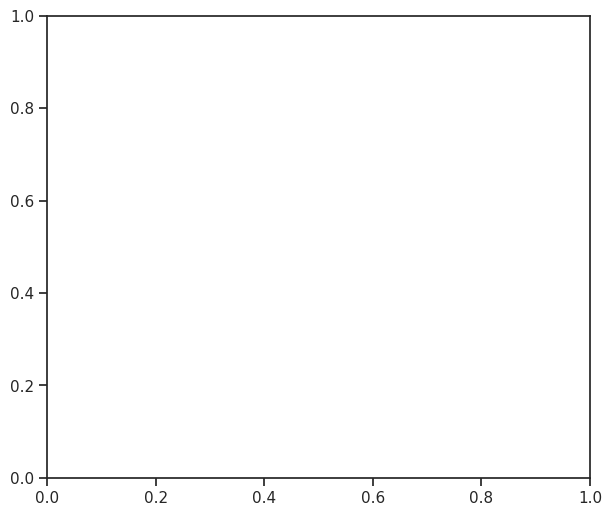

In [18]:
t_cut_low = Time("2025-09-05T00:00:00", format="isot", scale="utc")
t_cut_high = Time("2026-05-03T00:00:00", format="isot", scale="utc")

sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))

# Add in points to show each observation
sns.pointplot(data=df.where((df.pwv/np.sin(np.deg2rad(df.el)) < 3) & (df.t_obs < t_cut_high.unix ) & (t_cut_low.unix < df.t_obs)), x="nets", y="labels", linestyle="none", marker="x", color="0.5", zorder=2)
sns.stripplot(df.where((df.pwv/np.sin(np.deg2rad(df.el)) < 3) & (df.t_obs < t_cut_high.unix)), x="nets", y="labels", hue="pwv", zorder=1)



ymax, ymin = ax.get_ylim()
xmax, xmin = ax.get_xlim()

pos_090 = len([label for label in set(df.labels.to_numpy()) if "090" in label]) - 0.5
pos_150 = pos_090 + len([label for label in set(df.labels.to_numpy()) if "150" in label])
pos_220 = pos_150 + len([label for label in set(df.labels.to_numpy()) if "220" in label])
pos_280 = pos_220 + len([label for label in set(df.labels.to_numpy()) if "280" in label])

#090 Goals
temp_conv = mu.temp_conv(T_B=2.725*u.Kelvin, flavor="MF", ch="MF_1", kind='baseline')
#plt.vlines(2.70*np.sqrt(12)/1.08, ymin = ymin, ymax = pos_090, label="v3r7 baseline", color="orange")
#plt.vlines(1.72*np.sqrt(12)/1.08, ymin = ymin, ymax = pos_090, label="v3r7 goal", color="blue")

plt.vlines(4.31*np.sqrt(12)/1.08, ymin = ymin, ymax = pos_090, label="v3r0 baseline", color=c_base)
plt.vlines(3.01*np.sqrt(12)/1.08, ymin = ymin, ymax = pos_090, label="v3r0 goal", color=c_goal)

#150 Goals
temp_conv = mu.temp_conv(T_B=2.725*u.Kelvin, flavor="MF", ch="MF_2", kind='baseline')
#plt.vlines(3.21*np.sqrt(12)/1.0, ymin = pos_090, ymax = pos_150, label=None, color="orange")
#plt.vlines(2.03*np.sqrt(12)/1.0, ymin = pos_090, ymax = pos_150, label=None, color="blue")

plt.vlines(4.01*np.sqrt(12)/1.0, ymin = pos_090, ymax = pos_150, label=None, color=c_base)
plt.vlines(2.50*np.sqrt(12)/1.0, ymin = pos_090, ymax = pos_150, label=None, color=c_goal)

#220 Goals
temp_conv = mu.temp_conv(T_B=2.725*u.Kelvin, flavor="UHF", ch="UHF_1", kind='baseline')
#plt.vlines(3.84*np.sqrt(6)/1.01, ymin = pos_150, ymax = pos_220, label=None, color="orange")
#plt.vlines(2.41*np.sqrt(6)/1.01, ymin = pos_150, ymax = pos_220, label=None, color="blue")

plt.vlines(4.71*np.sqrt(6)/1.0, ymin = pos_150, ymax = pos_220, label=None, color=c_base)
plt.vlines(3.16*np.sqrt(6)/1.0, ymin = pos_150, ymax = pos_220, label=None, color=c_goal)

#280 Goals
temp_conv = mu.temp_conv(T_B=2.725*u.Kelvin, flavor="UHF", ch="UHF_2", kind='baseline')
#plt.vlines(8.61*np.sqrt(6)/1.0, ymin = pos_220, ymax = ymax, label=None, color="orange")
#plt.vlines(5.95*np.sqrt(6)/1.0, ymin = pos_220, ymax = ymax, label=None, color="blue")

plt.vlines(6.60*np.sqrt(6)/1.0, ymin = pos_220, ymax = ymax, label=None, color=c_base)
plt.vlines(4.63*np.sqrt(6)/1.0, ymin = pos_220, ymax = ymax, label=None, color=c_goal)

plt.hlines([pos_090, pos_150, pos_220], xmin=xmin, xmax=xmax, color="0.5")


plt.xlim(5, 35)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(xlabel="NET ($\mu K_{RJ} \sqrt{s}$)", ylabel="")
sns.despine(trim=True, left=True)

plt.legend()
#f.savefig("./plts/nets/nets_may27.pdf", dpi=600, bbox_inches='tight')
#f.savefig("./plts/nets/nets_may27.png", dpi=600, bbox_inches='tight')

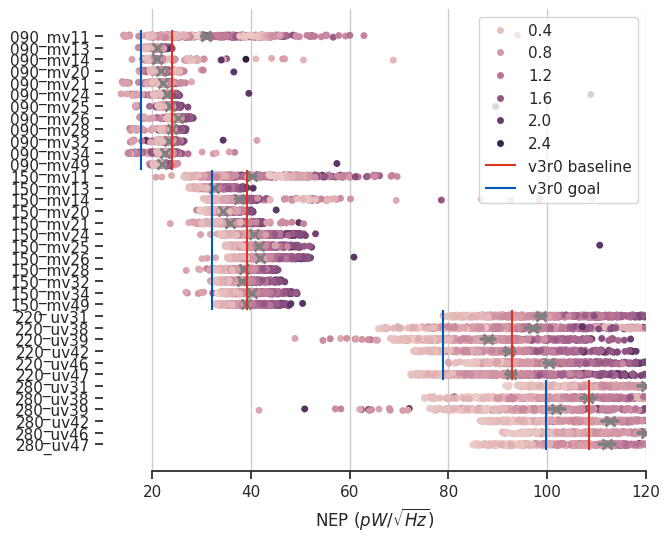

In [181]:
t_cut_low = Time("2024-09-12T00:00:00", format="isot", scale="utc")
t_cut_high = Time("2026-05-03T00:00:00", format="isot", scale="utc")

sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))

# Add in points to show each observation
sns.pointplot(data=df.where((df.pwv/np.sin(np.deg2rad(df.el)) < 3) & (df.t_obs < t_cut_high.unix) & (t_cut_low.unix < df.t_obs)), x="neps", y="labels", linestyle="none", marker="x", color="0.5", zorder=2)
sns.stripplot(df.where((df.pwv/np.sin(np.deg2rad(df.el)) < 3) & (df.t_obs < t_cut.unix) & (t_cut_low.unix < df.t_obs)), x="neps", y="labels", hue="pwv", zorder=1)



ymax, ymin = ax.get_ylim()

pos_090 = len([label for label in set(df.labels.to_numpy()) if "090" in label]) - 0.5
pos_150 = pos_090 + len([label for label in set(df.labels.to_numpy()) if "150" in label])
pos_220 = pos_150 + len([label for label in set(df.labels.to_numpy()) if "220" in label])
pos_280 = pos_220 + len([label for label in set(df.labels.to_numpy()) if "280" in label])

#90 Goals
plt.vlines(24.04, ymin = ymin, ymax = pos_090, label="v3r0 baseline", color=c_base)
plt.vlines(17.70, ymin = ymin, ymax = pos_090, label="v3r0 goal", color=c_goal)

#150 Goals
plt.vlines(39.25, ymin = pos_090, ymax = pos_150, label=None, color=c_base)
plt.vlines(32.13, ymin = pos_090, ymax = pos_150, label=None, color=c_goal)

#220 Goals
plt.vlines(92.86, ymin = pos_150, ymax = pos_220, label=None, color=c_base)
plt.vlines(78.89, ymin = pos_150, ymax = pos_220, label=None, color=c_goal)

#280 Goals
plt.vlines(108.63, ymin = pos_220, ymax = ymax, label=None, color=c_base)
plt.vlines(99.79, ymin = pos_220, ymax = ymax, label=None, color=c_goal)


plt.xlim(10, 120)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(xlabel="NEP ($pW / \sqrt{Hz}$)", ylabel="")
sns.despine(trim=True, left=True)

plt.legend()
#f.savefig("./plts/nets/neps.pdf", dpi=600, bbox_inches='tight')
#f.savefig("./plts/nets/neps.png", dpi=600, bbox_inches='tight')

## Combined by Frequency

In [206]:
obs_ids_090 = []
obs_ids_150 = []

for key in net_dict.keys():
    if "mv" in key:
        obs_ids_090.append(net_dict[key]["090"]["obs"])
        obs_ids_150.append(net_dict[key]["150"]["obs"])
        
obs_ids_220 = []
obs_ids_280 = []

for key in net_dict.keys():
    if "uv" in key:
        obs_ids_220.append(net_dict[key]["220"]["obs"])
        obs_ids_280.append(net_dict[key]["280"]["obs"])

In [204]:
times_090 = mu.get_matching_obs(obs_ids_090)
times_150 = mu.get_matching_obs(obs_ids_150)

times_220 = mu.get_matching_obs(obs_ids_220)
times_280 = mu.get_matching_obs(obs_ids_280)


In [200]:
uv_keys = ['uv47', 'uv31', 'uv38', 'uv46', 'uv42', 'uv39']
j=26
for i in range(len(uv_keys)):
    print(net_dict[uv_keys[i]]["280"]["nets"][times_280[i][j]])
    print(net_dict[uv_keys[i]]["280"]["obs"][times_280[i][j]])
    print(net_dict[uv_keys[i]]["280"]["pwv"][times_280[i][j]]/np.sin(np.deg2rad(net_dict[uv_keys[i]]["280"]["el"][times_280[i][j]])))

915.32183431394
obs_1746900233_lati5_111
2.474131304019188
1378.4067743182004
obs_1746900233_lati5_111
2.474131304019188
271.09214212966003
obs_1746900230_latc1_111
2.463368837281162
792.4533126145906
obs_1746900230_latc1_111
2.463368837281162
inf
obs_1746900233_lati5_111
2.474131304019188
inf
obs_1746900230_latc1_111
2.463368837281162


In [160]:
net_dict["uv31"]["280"]["pwv"][15]/np.sin(np.deg2rad(net_dict["uv31"]["280"]["el"][15]))

np.float64(1.1965624567602782)

In [174]:
df_freq.where((df_freq.labels == "f280") & (df_freq.pwvs_sinel<3) & (df_freq.t_obs < t_cut.unix) & (df_freq.nets < 50))

,labels,nets,pwv,pwvs_sinel,t_obs
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
1069,f280,39.237666,0.802800,1.248935,1.750825e+09
1070,f280,49.499067,0.903366,1.405400,1.750829e+09
1071,f280,43.386935,1.000641,1.556728,1.750832e+09
1072,NaN,NaN,NaN,NaN,NaN


In [196]:
filtered_df = df_freq[(df_freq.labels == "f280") & (df_freq.pwvs_sinel<3) & (df_freq.nets>40)]# & (df.t_obs < t_cut_high.unix) & (t_cut_low.unix < df.t_obs) & (df_freq.nets < 50)]

In [198]:
filtered_df.t_obs

887     1.746898e+09
888     1.746900e+09
892     1.747098e+09
897     1.747117e+09
900     1.747183e+09
            ...     
1047    1.750677e+09
1048    1.750687e+09
1070    1.750829e+09
1071    1.750832e+09
1073    1.750862e+09
Name: t_obs, Length: 112, dtype: float64

In [250]:
nets_090 = np.zeros(times_090.shape)
nets_150 = np.zeros(times_150.shape)
t_obs_090 = np.zeros(times_090.shape[1])
t_obs_150 = np.zeros(times_150.shape[1])
new_obs_ids_090 = []
new_obs_ids_150 = []
ndets_090 = np.zeros(times_090.shape)
ndets_150 = np.zeros(times_150.shape)
pwvs_sinel_090 = 0
pwvs_090 = 0
pwvs_sinel_150 = 0
pwvs_150 = 0

temp_conv_090 = mu.temp_conv(T_B=2.725*u.Kelvin, flavor="MF", ch="MF_1", kind='baseline')
temp_conv_150 = mu.temp_conv(T_B=2.725*u.Kelvin, flavor="MF", ch="MF_2", kind='baseline')
temp_conv_220 = mu.temp_conv(T_B=2.725*u.Kelvin, flavor="UHF", ch="UHF_1", kind='baseline')
temp_conv_280 = mu.temp_conv(T_B=2.725*u.Kelvin, flavor="UHF", ch="UHF_2", kind='baseline')
i = 0
for key in net_dict.keys():
    if "mv" in key:
        nets_090[i] = np.array(net_dict[key]["090"]["nets"])[times_090[i]] * temp_conv_090
        ndets_090[i] += np.array(net_dict[key]["090"]["ndets"])[times_090[i]]
        if i==0:
            pwvs_sinel_090 = (np.array(net_dict[key]["090"]["pwv"])[times_090[i]])/np.sin(np.deg2rad(np.array(net_dict[key]["090"]["el"])))[times_090[i]]
            pwvs_090 = np.array(net_dict[key]["090"]["pwv"])[times_090[i]]   
            for j, obs_id in enumerate(np.array(obs_ids_090[i])[times_090[i]]):
                t_obs_090[j] = obs_id.split("_")[1]
                new_obs_ids_090.append(obs_id)

        i += 1
        
i = 0
for key in net_dict.keys():
    if "mv" in key:
        nets_150[i] = np.array(net_dict[key]["150"]["nets"])[times_150[i]] * temp_conv_150
        ndets_150[i] += np.array(net_dict[key]["150"]["ndets"])[times_150[i]]
        if i==0:
            pwvs_sinel_150 = (np.array(net_dict[key]["150"]["pwv"])[times_150[i]])/np.sin(np.deg2rad(np.array(net_dict[key]["150"]["el"])))[times_150[i]]
            pwvs_150 = np.array(net_dict[key]["150"]["pwv"])[times_150[i]] 
            for j, obs_id in enumerate(np.array(obs_ids_150[i])[times_150[i]]):
                t_obs_150[j] = obs_id.split("_")[1]
                new_obs_ids_150.append(obs_id)
                
        i += 1
        
nets_220 = np.zeros(times_220.shape)
nets_280 = np.zeros(times_280.shape)
t_obs_220 = np.zeros(times_220.shape[1])
t_obs_280 = np.zeros(times_280.shape[1])
new_obs_ids_220 = []
new_obs_ids_280 = []
ndets_220 = np.zeros(times_220.shape)
ndets_280 = np.zeros(times_280.shape)
pwvs_sinel_220 = 0
pwvs_220 = 0
pwvs_sinel_280 = 0
pwvs_280 = 0
i = 0        
for key in net_dict.keys():
    if "uv" in key:
        nets_220[i] = np.array(net_dict[key]["220"]["nets"])[times_220[i]] * temp_conv_220
        ndets_220[i] += np.array(net_dict[key]["220"]["ndets"])[times_220[i]]
        if i==0:
            pwvs_sinel_220 = (np.array(net_dict["uv31"]["220"]["pwv"])[times_220[i]])/np.sin(np.deg2rad(np.array(net_dict["uv31"]["220"]["el"])))[times_220[i]]
            pwvs_220 = np.array(net_dict["uv31"]["220"]["pwv"])[times_220[i]]  
            for j, obs_id in enumerate(np.array(obs_ids_220[i])[times_220[i]]):
                t_obs_220[j] = obs_id.split("_")[1]
                new_obs_ids_220.append(obs_id)
                

        i += 1
        
i = 0        
for key in net_dict.keys():
    if "uv" in key:
        nets_280[i] = np.array(net_dict[key]["280"]["nets"])[times_280[i]] * temp_conv_280
        ndets_280[i] += np.array(net_dict[key]["280"]["ndets"])[times_280[i]]

        if i==0:
            pwvs_sinel_280 = (np.array(net_dict["uv31"]["280"]["pwv"])[times_280[i]])/np.sin(np.deg2rad(np.array(net_dict["uv31"]["280"]["el"])))[times_280[i]]
            pwvs_280 = np.array(net_dict["uv31"]["280"]["pwv"])[times_280[i]] 
            for j, obs_id in enumerate(np.array(obs_ids_280[i])[times_280[i]]):
                t_obs_280[j] = obs_id.split("_")[1]
                new_obs_ids_280.append(obs_id)
                
        i += 1
        
        
nets_090_comb = np.zeros(times_090.shape[1])
nets_090 = nets_090.T
ndets_090 = np.sum(ndets_090, axis=0)
new_obs_ids_090 = np.array(new_obs_ids_090)

nets_150_comb = np.zeros(times_150.shape[1])
nets_150 = nets_150.T
ndets_150 = np.sum(ndets_150, axis=0)
new_obs_ids_150 = np.array(new_obs_ids_150)

for i in range(len(nets_090)):
    nets_090_comb[i] = np.sum(1/(nets_090[i])**2)**(-1/2)
for i in range(len(nets_150)):
    nets_150_comb[i] = np.sum(1/(nets_150[i])**2)**(-1/2)
    
nets_220_comb = np.zeros(times_220.shape[1])
nets_220 = nets_220.T
ndets_220 = np.sum(ndets_220, axis=0)
new_obs_ids_220 = np.array(new_obs_ids_220)

nets_280_comb = np.zeros(times_280.shape[1])
nets_280 = nets_280.T
ndets_280 = np.sum(ndets_280, axis=0)
new_obs_ids_280 = np.array(new_obs_ids_280)

for i in range(len(nets_220)):
    nets_220_comb[i] = np.sum(1/(nets_220[i])**2)**(-1/2)
for i in range(len(nets_280)):
    nets_280_comb[i] = np.sum(1/(nets_280[i])**2)**(-1/2)


/tmp/ipykernel_44155/2328674642.py:115: RuntimeWarning: divide by zero encountered in scalar power
  nets_220_comb[i] = np.sum(1/(nets_220[i])**2)**(-1/2)
/tmp/ipykernel_44155/2328674642.py:117: RuntimeWarning: divide by zero encountered in scalar power
  nets_280_comb[i] = np.sum(1/(nets_280[i])**2)**(-1/2)


(array([ 31.,   0.,   5.,   0.,   4.,  15.,   8.,  12.,  18., 119.]),
 array([   7. ,  362.4,  717.8, 1073.2, 1428.6, 1784. , 2139.4, 2494.8,
        2850.2, 3205.6, 3561. ]),
 <BarContainer object of 10 artists>)

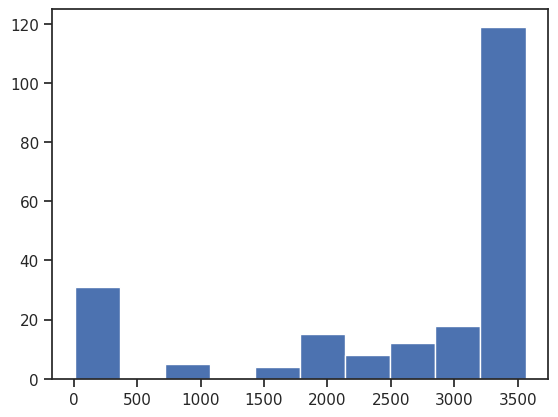

In [251]:
plt.hist(ndets_280)

In [254]:
new_obs_ids_280[np.isfinite(nets_280_comb) & (ndets_280 > 3000) & (nets_280_comb>38)]

array(['obs_1747074031_lati5_111', 'obs_1747092823_lati5_111',
       'obs_1747094130_lati5_111', 'obs_1747097718_lati5_111',
       'obs_1747101690_lati5_111', 'obs_1747105345_lati5_111',
       'obs_1747108933_lati5_111', 'obs_1747112537_lati5_111',
       'obs_1747117182_lati5_111', 'obs_1747187856_lati5_111',
       'obs_1747191483_lati5_111', 'obs_1747195073_lati5_111',
       'obs_1747198687_lati5_111', 'obs_1747203304_lati5_111',
       'obs_1747468284_lati5_111', 'obs_1747634434_lati5_111',
       'obs_1747648876_lati5_111', 'obs_1747650793_lati5_111',
       'obs_1747664921_lati5_111', 'obs_1747668160_lati5_111',
       'obs_1747685308_lati5_111', 'obs_1747963359_lati5_111',
       'obs_1747966947_lati5_111', 'obs_1747972507_lati5_111',
       'obs_1747974151_lati5_111', 'obs_1747978718_lati5_111',
       'obs_1747981986_lati5_111', 'obs_1747984859_lati5_111',
       'obs_1747990833_lati5_111', 'obs_1748049515_lati5_111',
       'obs_1748053112_lati5_111', 'obs_1748058664_lati

In [249]:
obs_1746900230_latc1_111

array(['obs_1750862488_lati5_111'], dtype='<U24')

(array([ 0.,  0.,  0.,  0.,  0.,  4., 16., 32., 39., 14., 16., 16.,  8.,
         6.,  3.,  1.,  5.,  1.,  1.]),
 array([10.        , 13.42105263, 16.84210526, 20.26315789, 23.68421053,
        27.10526316, 30.52631579, 33.94736842, 37.36842105, 40.78947368,
        44.21052632, 47.63157895, 51.05263158, 54.47368421, 57.89473684,
        61.31578947, 64.73684211, 68.15789474, 71.57894737, 75.        ]),
 <BarContainer object of 19 artists>)

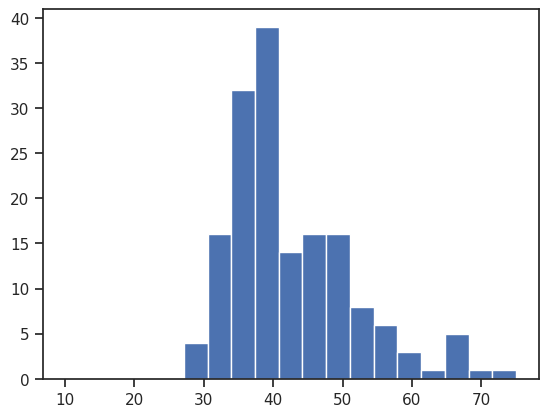

In [234]:
plt.hist(nets_280_comb[np.isfinite(nets_280_comb) & (ndets_280 > 2000)], bins=np.linspace(10,75,20))

In [222]:
nets = np.concatenate([nets_090_comb, nets_150_comb, nets_220_comb, nets_280_comb])
pwvs = np.concatenate([pwvs_090, pwvs_150, pwvs_220, pwvs_280])      
pwvs_sinel = np.concatenate([pwvs_sinel_090, pwvs_sinel_150, pwvs_sinel_220, pwvs_sinel_280])  
labels = np.concatenate([["f090"]*len(pwvs_090), ["f150"]*len(pwvs_150), ["f220"]*len(pwvs_220), ["f280"]*len(pwvs_280)])
t_obs = np.concatenate([t_obs_090, t_obs_150, t_obs_220, t_obs_280])
ndets = np.concatenate([ndets_090, ndets_150, ndets_220, ndets_280])
obs_ids = np.concatenate([new_obs_ids_090, new_obs_ids_150, new_obs_ids_220, new_obs_ids_280])


df_freq = pd.DataFrame({'labels': labels, 'nets': nets, "pwv":pwvs, "pwvs_sinel":pwvs_sinel,"t_obs":t_obs,"ndets":ndets,"obs_ids":obs_ids})

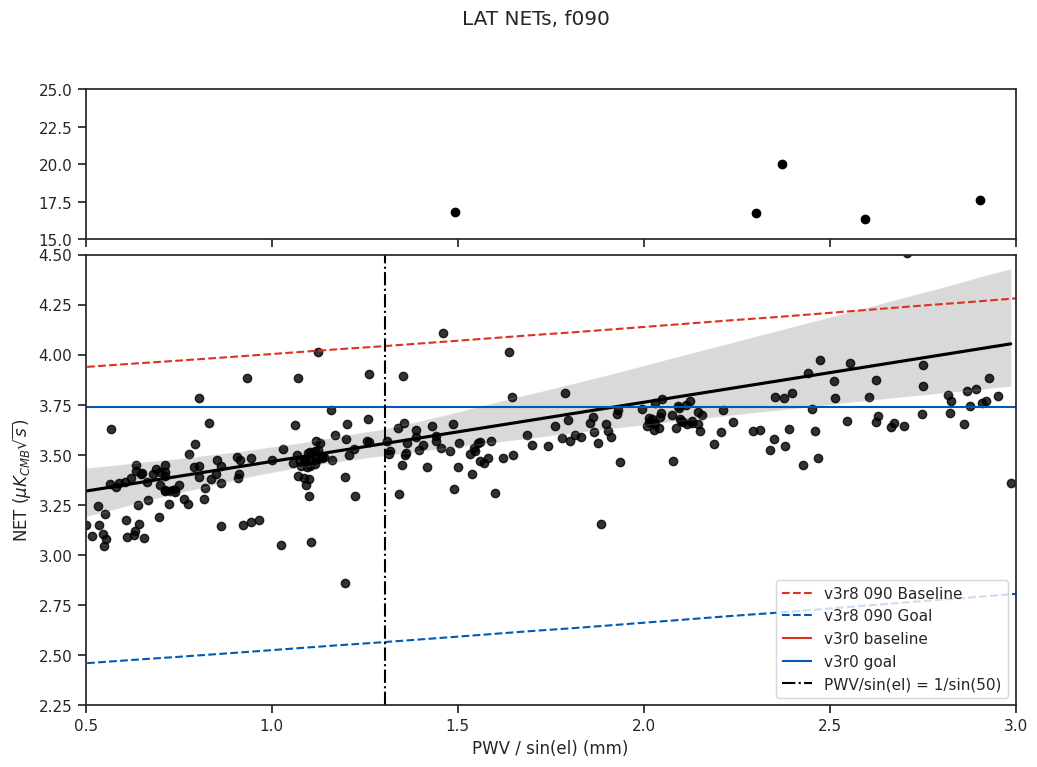

In [79]:
fig, (axu, axd) = plt.subplots(
    ncols=1,
    nrows=2,
    sharex=True,
    figsize=(12, 8),
    gridspec_kw=dict(height_ratios=[1, 3], wspace=0, hspace=0.05),
)


sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis

# Plot sepal width as a function of sepal_length across days
sns.regplot(
    ax=axd, data=df_freq.where((df_freq.labels == "f090") & (df_freq.pwvs_sinel<3) & (df.t_obs < t_cut_high.unix) & (t_cut_low.unix < df.t_obs) & (df_freq.nets < 15)),
    x="pwvs_sinel", y="nets", line_kws={"color":"black"}, scatter_kws={"color":"black"},
)

sns.regplot(
    ax=axu, data=df_freq.where((df_freq.labels == "f090") & (df_freq.pwvs_sinel<3) & (df.t_obs < t_cut_high.unix) & (t_cut_low.unix < df.t_obs) & (df_freq.nets > 15)),
    x="pwvs_sinel", y="nets", line_kws={"alpha":0}, scatter_kws={"alpha":1, "color":"black"}, fit_reg=False,
)

xmax = 3.0
plt.xlim(0.5,xmax)
ymin, ymax = (2.25, 4.5)
axd.set_ylim(ymin, ymax)
axu.set_ylim(15, 25)

plt.plot(wafer_net_c["pwv_sin_el"], 1e6*wafer_net_c['baseline']['MF']['MF_1']/np.sqrt(12), linestyle="--", label='v3r8 090 Baseline', color=c_base)
plt.plot(wafer_net_c["pwv_sin_el"], 1e6*wafer_net_c['goal']['MF']['MF_1']/np.sqrt(12), linestyle="--", label='v3r8 090 Goal', color=c_goal)

temp_conv_base = mu.temp_conv(T_B=2.725*u.Kelvin, flavor="MF", ch="MF_1", kind='baseline')
temp_conv_goal = mu.temp_conv(T_B=2.725*u.Kelvin, flavor="MF", ch="MF_1", kind='goal')

plt.hlines(4.31*temp_conv_base, xmin=0.5, xmax = xmax, label="v3r0 baseline", color=c_base)
plt.hlines(3.01*temp_conv_goal, xmin=0.5, xmax = xmax, label="v3r0 goal", color=c_goal)

plt.vlines(1/np.sin(np.deg2rad(50)), ymin, ymax, color="black", linestyle="dashdot", label = "PWV/sin(el) = 1/sin(50)")

plt.xlabel("PWV / sin(el) (mm)")
plt.ylabel("NET ($\mu K_{CMB} \sqrt{s}$)")

axu.set(xlabel="", ylabel="")

plt.legend(loc="lower right")

fig.suptitle("LAT NETs, f090")

plt.savefig("./plts/reanalysis/nets/nets_090.pdf", dpi=600, bbox_inches='tight')
plt.savefig("./plts/reanalysis/nets/nets_090.png", dpi=600, bbox_inches='tight')
plt.show()


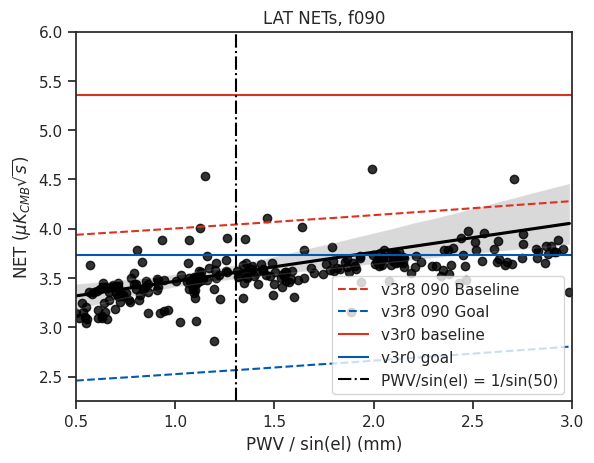

In [80]:
sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis

# Plot sepal width as a function of sepal_length across days
sns.regplot(
    data=df_freq.where((df_freq.labels == "f090") & (df_freq.pwvs_sinel<3) & (df.t_obs < t_cut_high.unix) & (t_cut_low.unix < df.t_obs) & (df_freq.nets < 15)),
    x="pwvs_sinel", y="nets", line_kws={"color":"black"}, scatter_kws={"color":"black"},
)

sns.regplot(
    data=df_freq.where((df_freq.labels == "f090") & (df_freq.pwvs_sinel<3) & (df.t_obs < t_cut_high.unix) & (t_cut_low.unix < df.t_obs) & (df_freq.nets > 15)),
    x="pwvs_sinel", y="nets", line_kws={"alpha":0}, scatter_kws={"alpha":1, "color":"black"}, fit_reg=False,
)

plt.plot(wafer_net_c["pwv_sin_el"], 1e6*wafer_net_c['baseline']['MF']['MF_1']/np.sqrt(12), linestyle="--", label='v3r8 090 Baseline', color=c_base)
plt.plot(wafer_net_c["pwv_sin_el"], 1e6*wafer_net_c['goal']['MF']['MF_1']/np.sqrt(12), linestyle="--", label='v3r8 090 Goal', color=c_goal)

temp_conv_base = mu.temp_conv(T_B=2.725*u.Kelvin, flavor="MF", ch="MF_1", kind='baseline')
temp_conv_goal = mu.temp_conv(T_B=2.725*u.Kelvin, flavor="MF", ch="MF_1", kind='goal')

#plt.hlines(2*4.31*temp_conv_base, xmin=0.5, xmax = xmax, label="Comm. Req.", color="black", linestyle="--")
plt.hlines(4.31*temp_conv_base, xmin=0.5, xmax = xmax, label="v3r0 baseline", color=c_base)
plt.hlines(3.01*temp_conv_goal, xmin=0.5, xmax = xmax, label="v3r0 goal", color=c_goal)

xmax = 3.0
plt.xlim(0.5,xmax)
ymin, ymax = (2.25, np.round(1.1*4.31*temp_conv_base))
plt.ylim(ymin, ymax)

plt.vlines(1/np.sin(np.deg2rad(50)), ymin, ymax, color="black", linestyle="dashdot", label = "PWV/sin(el) = 1/sin(50)")

plt.xlabel("PWV / sin(el) (mm)")
plt.ylabel("NET ($\mu K_{CMB} \sqrt{s}$)")

plt.legend(loc="lower right")

plt.title("LAT NETs, f090")

#plt.savefig("./plts/nets/nets_090_no_zoom.pdf", dpi=600, bbox_inches='tight')
#plt.savefig("./plts/nets/nets_090_no_zoom.png", dpi=600, bbox_inches='tight')
plt.show()

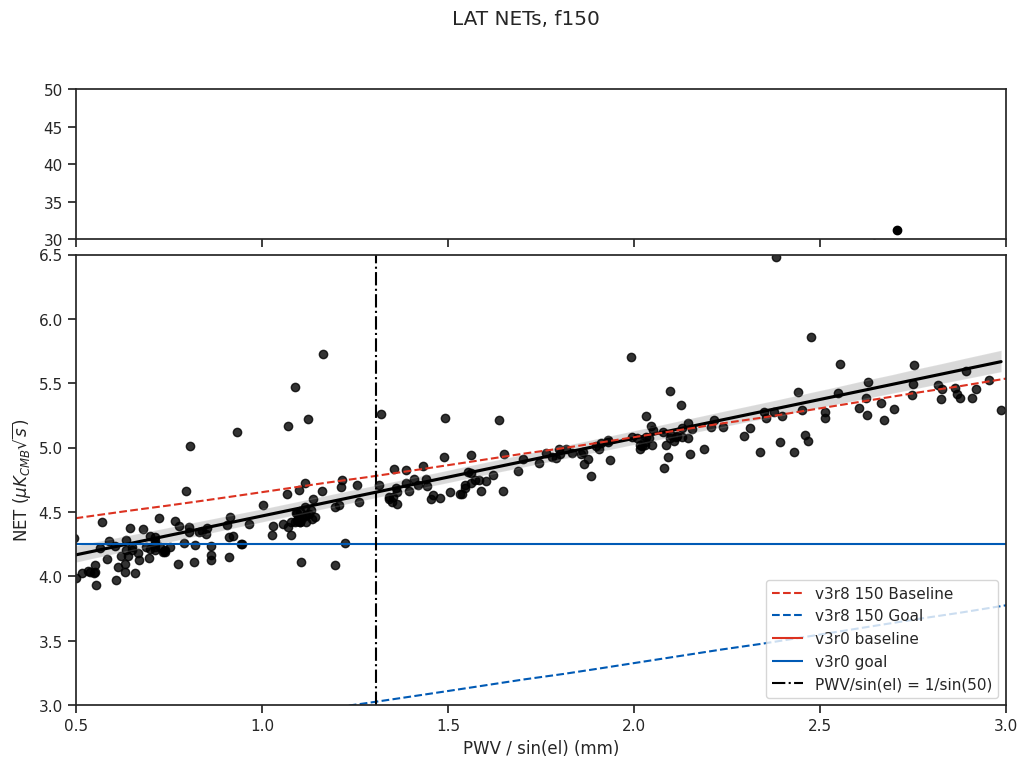

In [81]:
fig, (axu, axd) = plt.subplots(
    ncols=1,
    nrows=2,
    sharex=True,
    figsize=(12, 8),
    gridspec_kw=dict(height_ratios=[1, 3], wspace=0, hspace=0.05),
)


sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis

# Plot sepal width as a function of sepal_length across days
sns.regplot(
    ax=axd, data=df_freq.where((df_freq.labels == "f150") & (df_freq.pwvs_sinel<3) & (df.t_obs < t_cut_high.unix) & (t_cut_low.unix < df.t_obs) & (df_freq.nets < 10)),
    x="pwvs_sinel", y="nets", line_kws={"color":"black"}, scatter_kws={"color":"black"},
)

sns.regplot(
    ax=axu, data=df_freq.where((df_freq.labels == "f150") & (df_freq.pwvs_sinel<3) & (df.t_obs < t_cut_high.unix) & (t_cut_low.unix < df.t_obs) & (df_freq.nets > 10)),
    x="pwvs_sinel", y="nets", line_kws={"alpha":0}, scatter_kws={"alpha":1, "color":"black"}, fit_reg=False,
)

xmax = 3.0
plt.xlim(0.5,xmax)
ymin, ymax = (3, 6.5)
axd.set_ylim(ymin, ymax)
axu.set_ylim(30, 50)

plt.plot(wafer_net_c["pwv_sin_el"], 1e6*wafer_net_c['baseline']['MF']['MF_2']/np.sqrt(12), linestyle='--', label='v3r8 150 Baseline', color=c_base)
plt.plot(wafer_net_c["pwv_sin_el"], 1e6*wafer_net_c['goal']['MF']['MF_2']/np.sqrt(12), linestyle='--', label='v3r8 150 Goal', color=c_goal)

temp_conv_base = mu.temp_conv(T_B=2.725*u.Kelvin, flavor="MF", ch="MF_2", kind='baseline')
temp_conv_goal = mu.temp_conv(T_B=2.725*u.Kelvin, flavor="MF", ch="MF_2", kind='goal')

plt.hlines(4.01*temp_conv_base, xmin=0.5, xmax = xmax, label="v3r0 baseline", color=c_base)
plt.hlines(2.50*temp_conv_goal, xmin=0.5, xmax = xmax, label="v3r0 goal", color=c_goal)

plt.vlines(1/np.sin(np.deg2rad(50)), ymin, ymax, color="black", linestyle="dashdot", label = "PWV/sin(el) = 1/sin(50)")

plt.xlabel("PWV / sin(el) (mm)")
plt.ylabel("NET ($\mu K_{CMB} \sqrt{s}$)")

axu.set(xlabel="", ylabel="")

plt.legend(loc="lower right")

fig.suptitle("LAT NETs, f150")

plt.savefig("./plts/reanalysis/nets/nets_150.pdf", dpi=600, bbox_inches='tight')
plt.savefig("./plts/reanalysis/nets/nets_150.png", dpi=600, bbox_inches='tight')
plt.show()

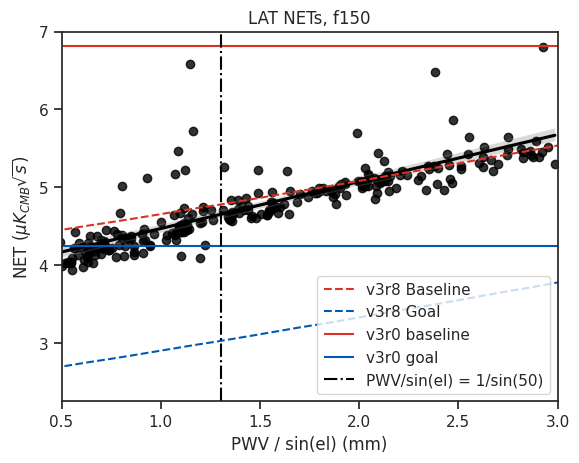

In [82]:
sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis

# Plot sepal width as a function of sepal_length across days
sns.regplot(
    data=df_freq.where((df_freq.labels == "f150") & (df_freq.pwvs_sinel<3) & (df.t_obs < t_cut_high.unix) & (t_cut_low.unix < df.t_obs) & (df_freq.nets < 10)),
    x="pwvs_sinel", y="nets", line_kws={"color":"black"}, scatter_kws={"color":"black"},
)

sns.regplot(
    data=df_freq.where((df_freq.labels == "f150") & (df_freq.pwvs_sinel<3) & (df.t_obs < t_cut_high.unix) & (t_cut_low.unix < df.t_obs) & (df_freq.nets > 10)),
    x="pwvs_sinel", y="nets", line_kws={"alpha":0}, scatter_kws={"alpha":1, "color":"black"}, fit_reg=False,
)

plt.plot(wafer_net_c["pwv_sin_el"], 1e6*wafer_net_c['baseline']['MF']['MF_2']/np.sqrt(12), linestyle="--", label='v3r8 Baseline', color=c_base)
plt.plot(wafer_net_c["pwv_sin_el"], 1e6*wafer_net_c['goal']['MF']['MF_2']/np.sqrt(12), linestyle="--", label='v3r8 Goal', color=c_goal)

temp_conv_base = mu.temp_conv(T_B=2.725*u.Kelvin, flavor="MF", ch="MF_2", kind='baseline')
temp_conv_goal = mu.temp_conv(T_B=2.725*u.Kelvin, flavor="MF", ch="MF_2", kind='goal')

#plt.hlines(2*4.01*temp_conv_base, xmin=0.5, xmax = xmax, label="Comm. Rec.", color="black", linestyle="--")
plt.hlines(4.01*temp_conv_base, xmin=0.5, xmax = xmax, label="v3r0 baseline", color=c_base)
plt.hlines(2.50*temp_conv_goal, xmin=0.5, xmax = xmax, label="v3r0 goal", color=c_goal)

xmax = 3.0
plt.xlim(0.5,xmax)
ymin, ymax = (2.25, np.round(1.1*4.01*temp_conv_base))
plt.ylim(ymin, ymax)

plt.vlines(1/np.sin(np.deg2rad(50)), ymin, ymax, color="black", linestyle="dashdot", label = "PWV/sin(el) = 1/sin(50)")

plt.xlabel("PWV / sin(el) (mm)")
plt.ylabel("NET ($\mu K_{CMB} \sqrt{s}$)")

plt.legend(loc="lower right")

plt.title("LAT NETs, f150")

#plt.savefig("./plts/nets/nets_150_no_zoom.pdf", dpi=600, bbox_inches='tight')
#plt.savefig("./plts/nets/nets_150_no_zoom.png", dpi=600, bbox_inches='tight')
plt.show()

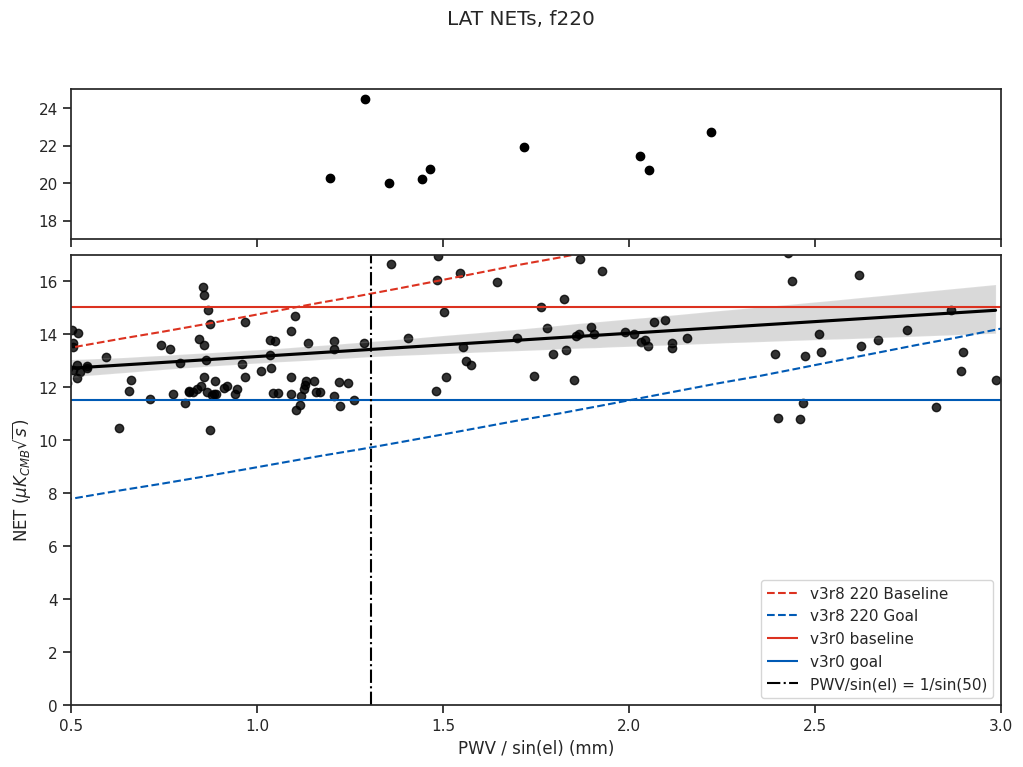

In [83]:
fig, (axu, axd) = plt.subplots(
    ncols=1,
    nrows=2,
    sharex=True,
    figsize=(12, 8),
    gridspec_kw=dict(height_ratios=[1, 3], wspace=0, hspace=0.05),
)


sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis

# Plot sepal width as a function of sepal_length across days
sns.regplot(
    ax=axd, data=df_freq.where((df_freq.labels == "f220") & (df_freq.pwvs_sinel<3) & (df.t_obs < t_cut_high.unix) & (t_cut_low.unix < df.t_obs) & (df_freq.nets < 20)),
    x="pwvs_sinel", y="nets", line_kws={"color":"black"}, scatter_kws={"color":"black"},
)

sns.regplot(
    ax=axu, data=df_freq.where((df_freq.labels == "f220") & (df_freq.pwvs_sinel<3) & (df.t_obs < t_cut_high.unix) & (t_cut_low.unix < df.t_obs) & (df_freq.nets > 20)),
    x="pwvs_sinel", y="nets", line_kws={"alpha":0}, scatter_kws={"alpha":1, "color":"black"}, fit_reg=False,
)

xmax = 3.0
plt.xlim(0.5,xmax)
ymin, ymax = (0, 17)
axd.set_ylim(ymin, ymax)
axu.set_ylim(17, 25)

plt.plot(wafer_net_c["pwv_sin_el"], 1e6*wafer_net_c['baseline']['UHF']['UHF_1']/np.sqrt(6), linestyle='--', label='v3r8 220 Baseline', color=c_base)
plt.plot(wafer_net_c["pwv_sin_el"], 1e6*wafer_net_c['goal']['UHF']['UHF_1']/np.sqrt(6), linestyle='--', label='v3r8 220 Goal', color=c_goal)

temp_conv_base = mu.temp_conv(T_B=2.725*u.Kelvin, flavor="UHF", ch="UHF_1", kind='baseline')
temp_conv_goal = mu.temp_conv(T_B=2.725*u.Kelvin, flavor="UHF", ch="UHF_1", kind='goal')

plt.hlines(4.71*temp_conv_base, xmin=0.5, xmax = xmax, label="v3r0 baseline", color=c_base)
plt.hlines(3.61*temp_conv_goal, xmin=0.5, xmax = xmax, label="v3r0 goal", color=c_goal)

plt.vlines(1/np.sin(np.deg2rad(50)), ymin, ymax, color="black", linestyle="dashdot", label = "PWV/sin(el) = 1/sin(50)")

plt.xlabel("PWV / sin(el) (mm)")
plt.ylabel("NET ($\mu K_{CMB} \sqrt{s}$)")

axu.set(xlabel="", ylabel="")

plt.legend(loc="lower right")

fig.suptitle("LAT NETs, f220")

#plt.savefig("./plts/nets/nets_220.pdf", dpi=600, bbox_inches='tight')
#plt.savefig("./plts/nets/nets_220.png", dpi=600, bbox_inches='tight')
plt.show()

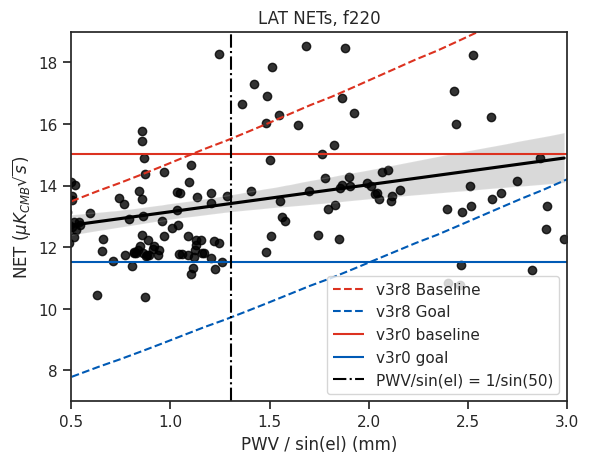

In [84]:
sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis

# Plot sepal width as a function of sepal_length across days
sns.regplot(
    data=df_freq.where((df_freq.labels == "f220") & (df_freq.pwvs_sinel<3) & (df.t_obs < t_cut_high.unix) & (t_cut_low.unix < df.t_obs) & (df_freq.nets < 20)),
    x="pwvs_sinel", y="nets", line_kws={"color":"black"}, scatter_kws={"color":"black"},
)

sns.regplot(
    data=df_freq.where((df_freq.labels == "f220") & (df_freq.pwvs_sinel<3) & (df.t_obs < t_cut_high.unix) & (t_cut_low.unix < df.t_obs) & (df_freq.nets > 20)),
    x="pwvs_sinel", y="nets", line_kws={"alpha":0}, scatter_kws={"alpha":1, "color":"black"}, fit_reg=False,
)

plt.plot(wafer_net_c["pwv_sin_el"], 1e6*wafer_net_c['baseline']['UHF']['UHF_1']/np.sqrt(6), linestyle="--", label='v3r8 Baseline', color=c_base)
plt.plot(wafer_net_c["pwv_sin_el"], 1e6*wafer_net_c['goal']['UHF']['UHF_1']/np.sqrt(6), linestyle="--", label='v3r8 Goal', color=c_goal)

temp_conv_base = mu.temp_conv(T_B=2.725*u.Kelvin, flavor="UHF", ch="UHF_1", kind='baseline')
temp_conv_goal = mu.temp_conv(T_B=2.725*u.Kelvin, flavor="UHF", ch="UHF_1", kind='goal')

#plt.hlines(2*4.71*temp_conv_base, xmin=0.5, xmax = xmax, label="Comm. Rec.", color="black", linestyle="--")
plt.hlines(4.71*temp_conv_base, xmin=0.5, xmax = xmax, label="v3r0 baseline", color=c_base)
plt.hlines(3.61*temp_conv_goal, xmin=0.5, xmax = xmax, label="v3r0 goal", color=c_goal)

xmax = 3.0
plt.xlim(0.5,xmax)
ymin, ymax = (7, np.round(1.25*4.71*temp_conv_base))
plt.ylim(ymin, ymax)

plt.vlines(1/np.sin(np.deg2rad(50)), ymin, ymax, color="black", linestyle="dashdot", label = "PWV/sin(el) = 1/sin(50)")

plt.xlabel("PWV / sin(el) (mm)")
plt.ylabel("NET ($\mu K_{CMB} \sqrt{s}$)")

plt.legend(loc="lower right")

plt.title("LAT NETs, f220")

#plt.savefig("./plts/nets/nets_220_no_zoom.pdf", dpi=600, bbox_inches='tight')
#plt.savefig("./plts/nets/nets_220_no_zoom.png", dpi=600, bbox_inches='tight')
plt.show()

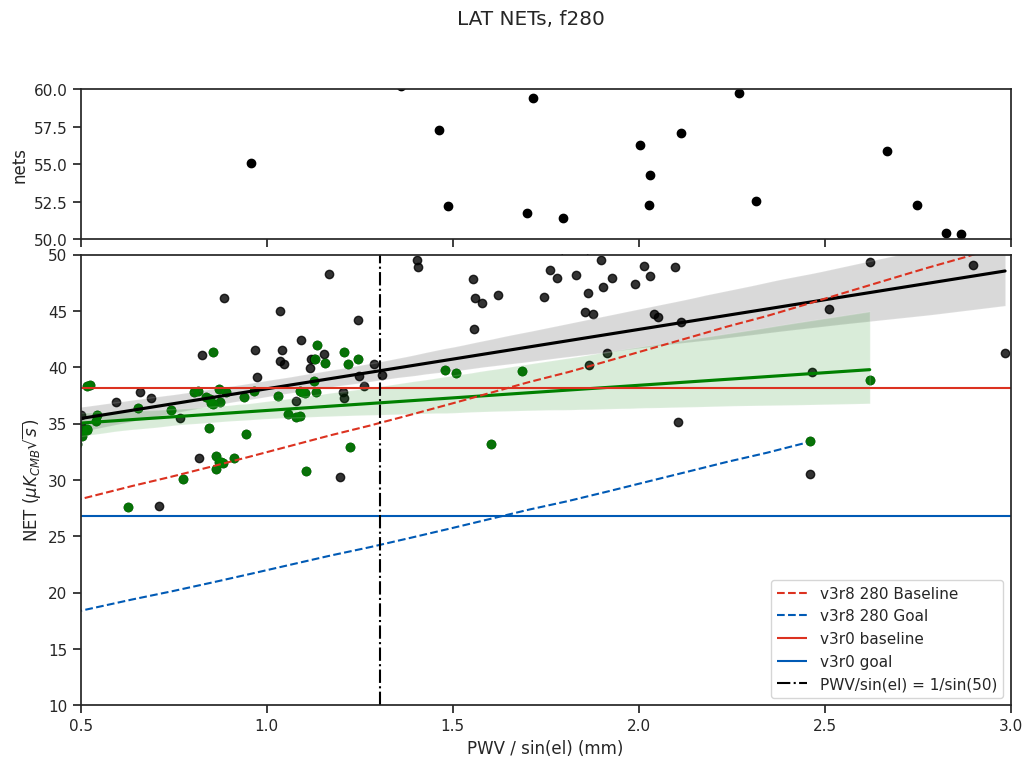

In [239]:
fig, (axu, axd) = plt.subplots(
    ncols=1,
    nrows=2,
    sharex=True,
    figsize=(12, 8),
    gridspec_kw=dict(height_ratios=[1, 3], wspace=0, hspace=0.05),
)


sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis

# Plot sepal width as a function of sepal_length across days
sns.regplot(
    ax=axd, data=df_freq.where((df_freq.labels == "f280") & (df_freq.pwvs_sinel<3) & (df.t_obs < t_cut_high.unix) & (t_cut_low.unix < df.t_obs) & (df_freq.nets < 50)),
    x="pwvs_sinel", y="nets", line_kws={"color":"black"}, scatter_kws={"color":"black"},
)

sns.regplot(
    ax=axd, data=df_freq.where((df_freq.labels == "f280") & (df_freq.pwvs_sinel<3) & (df.t_obs < t_cut_high.unix) & (t_cut_low.unix < df.t_obs) & (df_freq.nets < 50) & (df_freq.ndets > 3500)),
    x="pwvs_sinel", y="nets", line_kws={"color":"green"}, scatter_kws={"color":"green"},
)

sns.regplot(
    ax=axu, data=df_freq.where((df_freq.labels == "f280") & (df_freq.pwvs_sinel<3) & (df.t_obs < t_cut_high.unix) & (t_cut_low.unix < df.t_obs) & (df_freq.nets > 50)),
    x="pwvs_sinel", y="nets", line_kws={"alpha":0}, scatter_kws={"alpha":1, "color":"black"}, fit_reg=False,
)

xmax = 3.0
plt.xlim(0.5,xmax)
ymin, ymax = (10, 50)
axd.set_ylim(ymin, ymax)
axu.set_ylim(50, 60)

plt.plot(wafer_net_c["pwv_sin_el"], 1e6*wafer_net_c['baseline']['UHF']['UHF_2']/np.sqrt(6), linestyle='--', label='v3r8 280 Baseline', color=c_base)
plt.plot(wafer_net_c["pwv_sin_el"], 1e6*wafer_net_c['goal']['UHF']['UHF_2']/np.sqrt(6), linestyle='--', label='v3r8 280 Goal', color=c_goal)

temp_conv_base = mu.temp_conv(T_B=2.725*u.Kelvin, flavor="UHF", ch="UHF_2", kind='baseline')
temp_conv_goal = mu.temp_conv(T_B=2.725*u.Kelvin, flavor="UHF", ch="UHF_2", kind='goal')

plt.hlines(6.60*temp_conv_base, xmin=0.5, xmax = xmax, label="v3r0 baseline", color=c_base)
plt.hlines(4.63*temp_conv_goal, xmin=0.5, xmax = xmax, label="v3r0 goal", color=c_goal)

plt.vlines(1/np.sin(np.deg2rad(50)), ymin, ymax, color="black", linestyle="dashdot", label = "PWV/sin(el) = 1/sin(50)")

plt.xlabel("PWV / sin(el) (mm)")
plt.ylabel("NET ($\mu K_{CMB} \sqrt{s}$)")

plt.legend()

fig.suptitle("LAT NETs, f280")

#plt.savefig("./plts/nets/nets_280.pdf", dpi=600, bbox_inches='tight')
#plt.savefig("./plts/nets/nets_280.png", dpi=600, bbox_inches='tight')
plt.show()

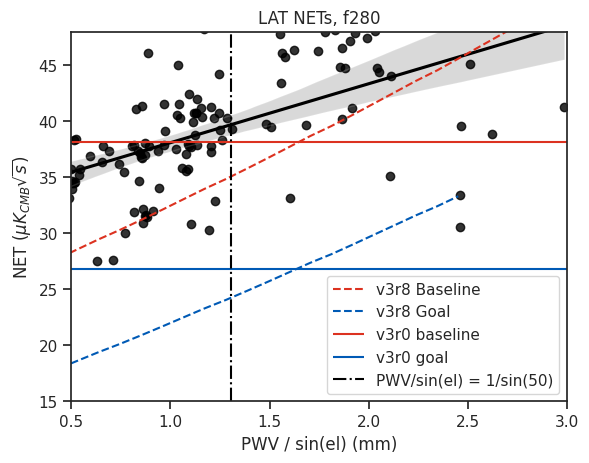

In [86]:
sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis

# Plot sepal width as a function of sepal_length across days
# Plot sepal width as a function of sepal_length across days
sns.regplot(
    data=df_freq.where((df_freq.labels == "f280") & (df_freq.pwvs_sinel<3) & (df.t_obs < t_cut_high.unix) & (t_cut_low.unix < df.t_obs) & (df_freq.nets < 50)),
    x="pwvs_sinel", y="nets", line_kws={"color":"black"}, scatter_kws={"color":"black"},
)

sns.regplot(
    data=df_freq.where((df_freq.labels == "f280") & (df_freq.pwvs_sinel<3) & (df.t_obs < t_cut_high.unix) & (t_cut_low.unix < df.t_obs) & (df_freq.nets > 50)),
    x="pwvs_sinel", y="nets", line_kws={"alpha":0}, scatter_kws={"alpha":1, "color":"black"}, fit_reg=False,
)

plt.plot(wafer_net_c["pwv_sin_el"], 1e6*wafer_net_c['baseline']['UHF']['UHF_2']/np.sqrt(6), linestyle="--", label='v3r8 Baseline', color=c_base)
plt.plot(wafer_net_c["pwv_sin_el"], 1e6*wafer_net_c['goal']['UHF']['UHF_2']/np.sqrt(6), linestyle="--", label='v3r8 Goal', color=c_goal)

temp_conv_base = mu.temp_conv(T_B=2.725*u.Kelvin, flavor="UHF", ch="UHF_2", kind='baseline')
temp_conv_goal = mu.temp_conv(T_B=2.725*u.Kelvin, flavor="UHF", ch="UHF_2", kind='goal')

#plt.hlines(2*6.60*temp_conv_base, xmin=0.5, xmax = xmax, label="Comm. Rec.", color="black", linestyle="--")
plt.hlines(6.60*temp_conv_base, xmin=0.5, xmax = xmax, label="v3r0 baseline", color=c_base)
plt.hlines(4.63*temp_conv_goal, xmin=0.5, xmax = xmax, label="v3r0 goal", color=c_goal)

xmax = 3.0
plt.xlim(0.5,xmax)
ymin, ymax = (15, np.round(1.25*6.60*temp_conv_base))
plt.ylim(ymin, ymax)

plt.vlines(1/np.sin(np.deg2rad(50)), ymin, ymax, color="black", linestyle="dashdot", label = "PWV/sin(el) = 1/sin(50)")

plt.xlabel("PWV / sin(el) (mm)")
plt.ylabel("NET ($\mu K_{CMB} \sqrt{s}$)")

plt.legend(loc="lower right")

plt.title("LAT NETs, f280")

plt.savefig("./plts/nets/nets_280_no_zoom.pdf", dpi=600, bbox_inches='tight')
plt.savefig("./plts/nets/nets_280_no_zoom.png", dpi=600, bbox_inches='tight')
plt.show()

# Yields

In [24]:
labels = []
pwvs = []
pwvs_sinel = []
els = []
yields = []
obs = []

pwv = pwv_interp()

freqs = ["090", "150", "220", "280"]
ufms = sorted(result_dict.keys())

for freq in freqs: #This is slighly inefficient but the ezest way to sort by freq then ufm
    for ufm in ufms:
        for key in net_dict.keys():
            if ufm not in key:
                continue
            for sub_key in net_dict[key].keys():
                if freq not in sub_key:
                    continue
                cur_obs = np.array(net_dict[key][sub_key]["obs"])
                cur_ndets = np.array(net_dict[key][sub_key]["ndets"])
                cur_el = np.array(net_dict[key][sub_key]["el"])
                cur_nets = np.array(net_dict[key][sub_key]["nets"])
                label = str(freq)+"_"+str(ufm)
                for j in range(len(cur_nets)):
                    cur_pwv = pwv(cur_obs[j].split("_")[1])
                    if cur_nets[j] <= 100 and cur_ndets[j] > 100: #very large nets are not real
                        labels.append(label)
                        pwvs.append(cur_pwv)
                        els.append(cur_el[j])
                        pwvs_sinel.append(cur_pwv/np.sin(np.deg2rad(cur_el[j])))
                        yields.append(cur_ndets[j]/860)
                        obs.append(cur_obs[j])


#get unique obs times
obs = set(obs)     
new_obs = []
times = []
for i, ob in enumerate(obs):
    if i == 0:
        new_obs.append(ob)
        times.append(float(ob.split("_")[1]))
        continue
    for time in times:
        if np.isclose(time, float(ob.split("_")[1])):
            continue
    new_obs.append(ob)
    times.append(float(ob.split("_")[1]))
    
for freq in freqs: #This is slighly inefficient but the ezest way to sort by freq then ufm
    for time in times:
        ndets = 0
        narrays = 0
        for key in net_dict.keys():
            for sub_key in net_dict[key].keys():
                if freq not in sub_key:
                    continue
                cur_obs = np.array(net_dict[key][sub_key]["obs"])
                for j in range(len(cur_obs)):
                    if np.isclose(time, float(cur_obs[j].split("_")[1])):

                        cur_ndets = np.array(net_dict[key][sub_key]["ndets"])
                        cur_nets = np.array(net_dict[key][sub_key]["nets"])
                        #if cur_nets[j] <= 100 and cur_ndets[j] > 100: #very large nets are not real
                        ndets += cur_ndets[j]
                        narrays += 860
                        cur_el = np.array(net_dict[key][sub_key]["el"][j])
                        cur_pwv = pwv(cur_obs[j].split("_")[1])     
        if narrays == 0: continue      
        labels.append(freq)
        pwvs.append(cur_pwv)
        els.append(cur_el)
        pwvs_sinel.append(cur_pwv/np.sin(np.deg2rad(cur_el)))
        yields.append(ndets/narrays)
    
labels = np.array(labels)
pwvs = np.array(pwvs)
els = np.array(els)
yields = np.array(yields)

df_yield = pd.DataFrame({'labels': labels,"pwv":pwvs, "el":els, "yields":yields, "pwvs_sinel":pwvs_sinel})

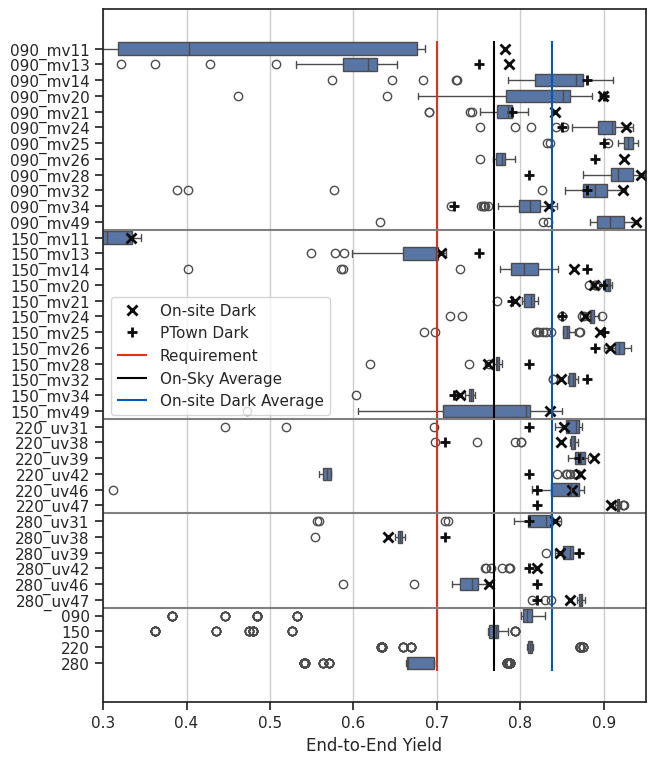

In [88]:
toby_yields = {'090_mv11':0.782, '090_mv13':0.786, '090_mv14':0.964, '090_mv20':0.899, '090_mv21':0.841, '090_mv24':0.926, 
               '090_mv25':0.961, '090_mv26':0.924, '090_mv28':0.944, '090_mv32':0.923, '090_mv34':0.834, '090_mv49':0.938,
               '150_mv11':0.334, '150_mv13':0.705, '150_mv14':0.864, '150_mv20':0.888, '150_mv21':0.794, '150_mv24':0.877,
               '150_mv25':0.895, '150_mv26':0.907, '150_mv28':0.761, '150_mv32':0.849, '150_mv34':0.728, '150_mv49':0.836,
               '220_uv31':0.852, '220_uv38':0.849, '220_uv39':0.888, '220_uv42':0.871, '220_uv46':0.862, '220_uv47':0.908,
               '280_uv31':0.841, '280_uv38':0.641, '280_uv39':0.847, '280_uv42':0.820, '280_uv46':0.763, '280_uv47':0.860
              }
toby_df = pd.DataFrame({"labels":toby_yields.keys(), "yields":toby_yields.values()})

ptown_yields = {'090_mv11':72.0, '090_mv13':0.75, '090_mv14':0.88, '090_mv20':0.90, '090_mv21':0.79, '090_mv24':0.85,
                '090_mv25':0.90, '090_mv26':0.89, '090_mv28':0.81, '090_mv32':0.88, '090_mv34':0.72, '090_mv49':np.nan,
                '220_uv31':0.81, '220_uv38':0.71, '220_uv39':0.87, '220_uv42':0.81, '220_uv46':0.82, '220_uv47':0.82,
                '150_mv11':72.0, '150_mv13':0.75, '150_mv14':0.88, '150_mv20':0.90, '150_mv21':0.79, '150_mv24':0.85,
                '150_mv25':0.90, '150_mv26':0.89, '150_mv28':0.81, '150_mv32':0.88, '150_mv34':0.72, '150_mv49':np.nan,
                '280_uv31':0.81, '280_uv38':0.71, '280_uv39':0.87, '280_uv42':0.81, '280_uv46':0.82, '280_uv47':0.82,
               }
ptown_df = pd.DataFrame({"labels":ptown_yields.keys(), "yields":ptown_yields.values()})

sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 9))

sns.boxplot(data=df_yield.where(df_yield.pwv/np.sin(np.deg2rad(df_yield.el)) <= 1 / np.sin(np.deg2rad(50))),
            x="yields", y="labels",
           )

sns.pointplot(data=toby_df, x="yields", y="labels", linestyle="none", marker="x", color="0.05", zorder=2, label="On-site Dark")
sns.pointplot(data=ptown_df, x="yields", y="labels", linestyle="none", marker="+", color="0.05", zorder=2, label="PTown Dark")

plt.xlim(0.3, 0.95)

ymax, ymin = ax.get_ylim()
xmax, xmin = ax.get_xlim()

plt.vlines(0.7, ymin=ymin, ymax=ymax, label="Requirement", color=c_base)
plt.vlines(np.nanmean(df.where(df.pwv/np.sin(np.deg2rad(df.el)) <= 1 / np.sin(np.deg2rad(50))).yields), ymin=ymin, ymax=ymax, label="On-Sky Average", color="black")
plt.vlines(np.nanmean(toby_df.yields), ymin=ymin, ymax=ymax, label="On-site Dark Average", color=c_goal)


pos_090 = len([label for label in set(df.labels.to_numpy()) if "090" in label]) - 0.5
pos_150 = pos_090 + len([label for label in set(df.labels.to_numpy()) if "150" in label])
pos_220 = pos_150 + len([label for label in set(df.labels.to_numpy()) if "220" in label])
pos_280 = pos_220 + len([label for label in set(df.labels.to_numpy()) if "280" in label])

plt.hlines([pos_090, pos_150, pos_220,pos_280], xmin=xmin, xmax=xmax, color="0.5")

plt.legend()

ax.xaxis.grid(True)
ax.set(xlabel="End-to-End Yield", ylabel="")

plt.savefig("plts/yield.png", dpi=600, bbox_inches='tight')
plt.savefig("plts/yield.pdf", dpi=600, bbox_inches='tight')

In [251]:
total_yield = []
pwvs = []
for time in times:
    ndets = 0
    narrays = 0
    for key in net_dict.keys():
        for sub_key in net_dict[key].keys():
            if freq not in sub_key:
                continue
            cur_obs = np.array(net_dict[key][sub_key]["obs"])
            for j in range(len(cur_obs)):
                if np.isclose(time, float(cur_obs[j].split("_")[1])):

                    cur_ndets = np.array(net_dict[key][sub_key]["ndets"])
                    cur_nets = np.array(net_dict[key][sub_key]["nets"])
                    #if cur_nets[j] <= 100 and cur_ndets[j] > 100: #very large nets are not real
                    ndets += cur_ndets[j]
                    narrays += 860
                    cur_el = np.array(net_dict[key][sub_key]["el"][j])
                    cur_pwv = pwv(cur_obs[j].split("_")[1])     
    if narrays == 0: continue      
    pwvs.append(cur_pwv/np.sin(np.deg2rad(cur_el)))
    total_yield.append(ndets/narrays)

df_total = pd.DataFrame({"yields":total_yield, "pwv":pwvs})

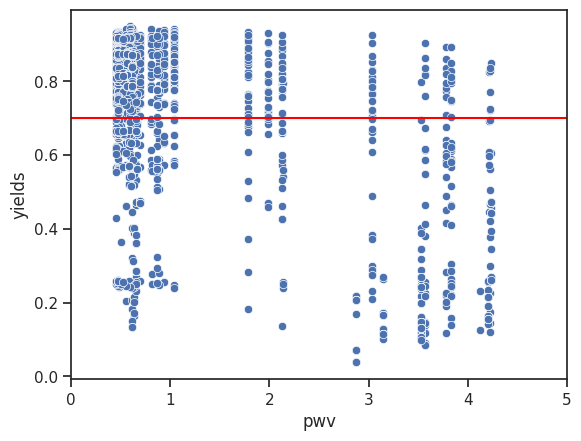

In [253]:

sns.scatterplot(df_yield, x="pwv", y="yields")

plt.xlim(0, 5)
plt.hlines(0.7, 0, 5, color="red")

In [285]:
# Define bins
bins = np.arange(0,5.25,0.25)
labels = np.arange(0.125, 5, 0.25)
# Bin the data
df['binned'] = pd.cut(df_yield.where(df_yield.yields > 0.5)['pwvs_sinel'], bins=bins, labels=labels, right=False)

# Calculate the average value for each bin
average_per_bin = df.groupby('binned')['yields'].mean()
std_per_bin = df.groupby('binned')['yields'].std()

/tmp/ipykernel_203881/2677165071.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_per_bin = df.groupby('binned')['yields'].mean()
/tmp/ipykernel_203881/2677165071.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  std_per_bin = df.groupby('binned')['yields'].std()


<function matplotlib.pyplot.xlabel(xlabel: 'str', fontdict: 'dict[str, Any] | None' = None, labelpad: 'float | None' = None, *, loc: "Literal['left', 'center', 'right'] | None" = None, **kwargs) -> 'Text'>

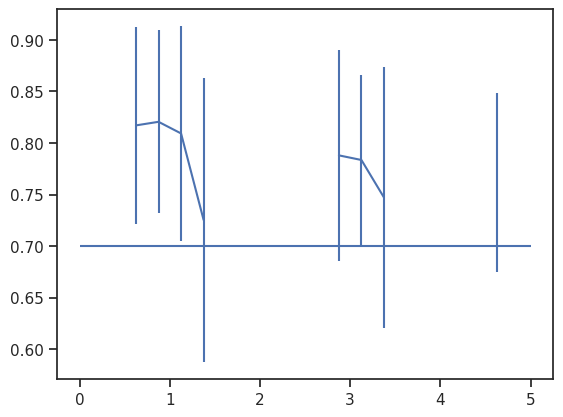

In [287]:
plt.errorbar(labels, average_per_bin, yerr=std_per_bin)

plt.hlines(0.7, 0, 5)
#plt.xlim(0,4.5)
#plt.ylim(0.5, 1)

plt.xlabel

## NEPs

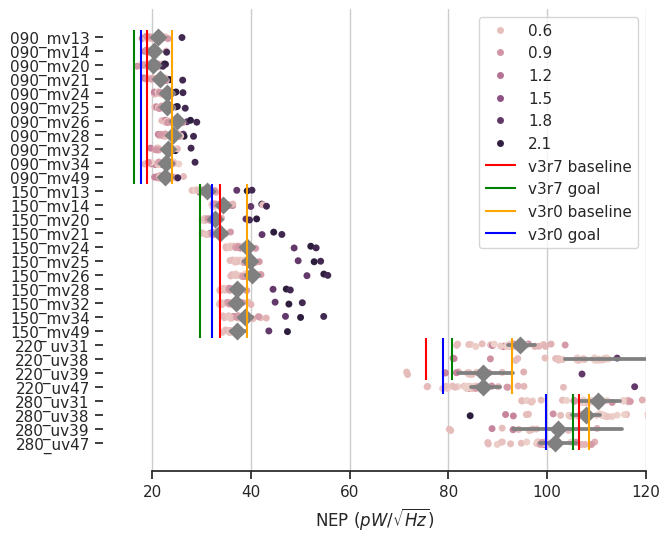

In [120]:
if False:
    ctx = core.Context('./smurf_det_preproc.yaml')


    obs_list = ctx.obsdb.query(
        f"timestamp > 1723783842 and timestamp < 1723900000 and type=='obs'"
    )
    neps_snork_090 = []
    neps_snork_150 = []

    for obs in obs_list:
        meta = ctx.get_meta(obs_list[9]["obs_id"]) 

        for i in [0,1]:
            bp = (meta.det_cal.bg % 4) // 2
            net_flag = (bp==i)

            cur_neps = meta.preprocess.noise.white_noise[net_flag] * meta.det_cal.phase_to_pW[net_flag]

            if i == 0:
                for j in range(len(cur_neps)):
                    if neps[j] == np.nan: 
                        continue
                    neps_snork_090.append(cur_neps[j])

            else:
                for j in range(len(cur_neps)):
                    if neps[j] == np.nan: 
                            continue
                    neps_snork_150.append(cur_neps[j])            


    neps_snork_090 = np.array(neps_snork_090)
    neps_snork_150 = np.array(neps_snork_150)
    baseline = 18.99

    plt.hist(neps_snork_090*1e6/baseline, bins = np.linspace(0,2, 20))

# Indv Det NETs

Text(0.5, 0, 'NEP (aW/rt(Hz))')

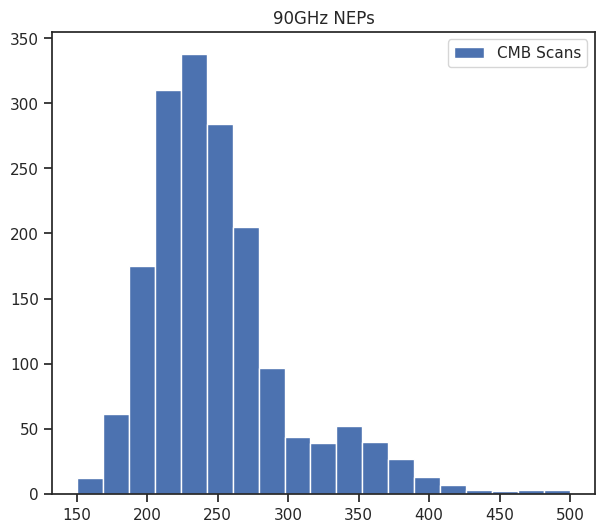

In [38]:
f, ax = plt.subplots(figsize=(7, 6))

#baseline_r0 = 24.04
#baseline_r7 = 18.99

#goal_r0 = 17.70
#goal_r7 = 16.37

#plt.hist(df[flags]*1e6/baseline_r0, bins = np.linspace(0,2, 20), label = "CMB Scans")
plt.hist(df.where((df.pwv < 3) & (np.char.find(str(df.labels), "090") != -1)).indv_nets, bins = np.linspace(150,500, 20), label = "CMB Scans")
ymax, ymin = ax.get_ylim()
#plt.vlines(baseline_r7/baseline_r0, ymin, ymax, label="baseline v3r7", color="red")
#plt.vlines(goal_r7/baseline_r0, ymin, ymax, label="goal v3r7", color="green")
#plt.vlines(baseline_r0/baseline_r0, ymin, ymax, label="baseline v3r0", color="orange")
#plt.vlines(goal_r0/baseline_r0, ymin, ymax, label="goal v3r0", color="blue")
#plt.xlabel("NEP/baseline")
plt.title("90GHz NEPs")
plt.legend()

def normalize(x):
    return x / baseline_r0
def denorm(x):
    return x * baseline_r0

#secax = ax.secondary_xaxis("top", functions=(denorm, normalize))
secax.set_xlabel("NEP (aW/rt(Hz))")

#f.savefig("./plts/nets/neps_090.pdf", dpi=600, bbox_inches='tight')
#f.savefig("./plts/nets/neps_090.png", dpi=600, bbox_inches='tight')

In [40]:
net_dict.keys()

dict_keys(['mv13', 'mv20', 'mv34', 'mv32', 'mv14', 'mv49', 'mv26', 'mv11', 'mv25', 'mv24', 'mv28', 'mv21', 'uv46', 'uv38', 'uv31', 'uv47', 'uv42', 'uv39', 'ufm'])

In [161]:
nep_labels = []
neps = []
cals = []
neis = []
obs = []
pwvs = []
els = []

freqs = ["090", "150", "220", "280"]
ufms = sorted(result_dict.keys())

for freq in freqs: #This is slighly inefficient but the ezest way to sort by freq then ufm
    for ufm in ufms:
        for key in net_dict.keys():
            if ufm not in key:
                continue
            for sub_key in net_dict[key].keys():
                if freq not in sub_key:
                    continue
                cur_abscals = np.array(net_dict[key][sub_key]["raw_cal"])
                cur_nets = np.array(net_dict[key][sub_key]["nets"])
                cur_neps =net_dict[key][sub_key]["neps"]
                cur_obs = np.array(net_dict[key][sub_key]["obs"])
                cur_ndets = np.array(net_dict[key][sub_key]["ndets"])
                cur_phicals = net_dict[key][sub_key]["phiconv"]
                cur_el = np.array(net_dict[key][sub_key]["el"])
                label = str(freq)+"_"+str(ufm)
                for j in range(len(cur_abscals)):
                    cur_pwv = pwv(cur_obs[j].split("_")[1])
                    if cur_nets[j] <= 100 and cur_ndets[j] > 100 and cur_pwv < 6: #very large nets are not real
                        for i, nep in enumerate(cur_neps[j]): 
                            neps.append(nep)
                            nep_labels.append(label)
                            cals.append(cur_phicals[j][i])
                            neis.append(nep/cur_phicals[j][i] * 9e6/(2 * np.pi))
                            obs.append(cur_obs[j])
                            pwvs.append(cur_pwv)
                            els.append(cur_el[j])
                    
nep_labels = np.array(nep_labels)
neps = np.array(neps)
neis = np.array(neis)
obs = np.array(obs)
cals = np.array(cals)
pwvs = np.array(pwvs)
els = np.array(els)

nep_df = pd.DataFrame({'labels': nep_labels,'obs': obs, "pwv":pwvs, "neps":neps, "neis":neis, "el":els, "cals":cals})

/tmp/ipykernel_114399/1512650899.py:35: RuntimeWarning: invalid value encountered in scalar divide
  neis.append(nep/cur_phicals[j][i] * 9e6/(2 * np.pi))


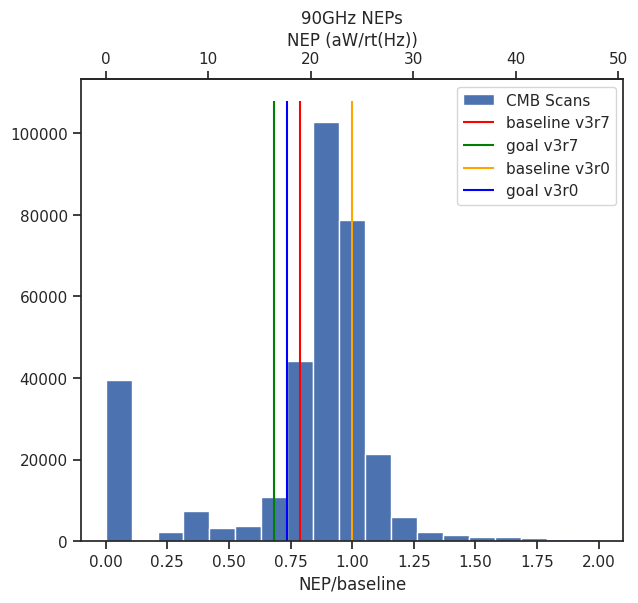

In [149]:
f, ax = plt.subplots(figsize=(7, 6))
flags = np.where(np.char.find(nep_labels, "090") != -1)[0]

baseline_r0 = 24.04
baseline_r7 = 18.99

goal_r0 = 17.70
goal_r7 = 16.37

plt.hist(neps[flags]*1e6/baseline_r0, bins = np.linspace(0,2, 20), label = "CMB Scans")
#plt.hist(neps_snork_090*1e6/baseline, bins = np.linspace(0,2, 20), label = "Snorkel Stare", density = True, alpha = 0.5)
ymax, ymin = ax.get_ylim()
plt.vlines(baseline_r7/baseline_r0, ymin, ymax, label="baseline v3r7", color="red")
plt.vlines(goal_r7/baseline_r0, ymin, ymax, label="goal v3r7", color="green")
plt.vlines(baseline_r0/baseline_r0, ymin, ymax, label="baseline v3r0", color="orange")
plt.vlines(goal_r0/baseline_r0, ymin, ymax, label="goal v3r0", color="blue")
plt.xlabel("NEP/baseline")
plt.title("90GHz NEPs")
plt.legend()

def normalize(x):
    return x / baseline_r0
def denorm(x):
    return x * baseline_r0

secax = ax.secondary_xaxis("top", functions=(denorm, normalize))
secax.set_xlabel("NEP (aW/rt(Hz))")

f.savefig("./plts/nets/neps_090.pdf", dpi=600, bbox_inches='tight')
f.savefig("./plts/nets/neps_090.png", dpi=600, bbox_inches='tight')

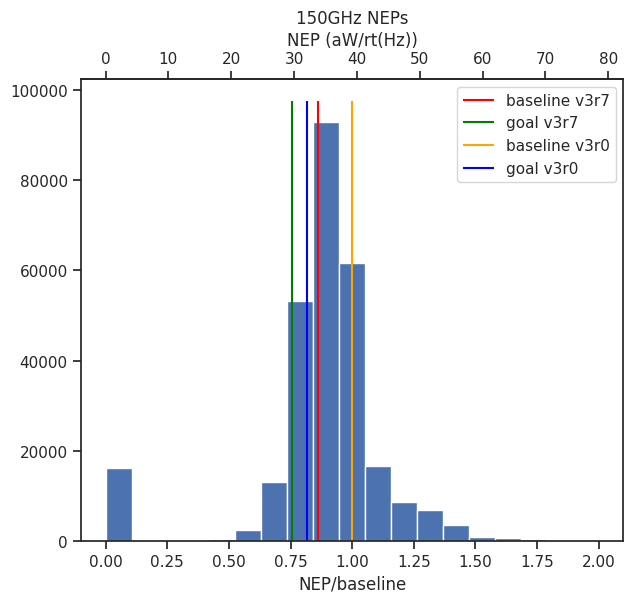

In [144]:
f, ax = plt.subplots(figsize=(7, 6))
flags = np.where(np.char.find(nep_labels, "150") != -1)[0]

baseline_r0 = 39.25
baseline_r7 = 33.81

goal_r0 = 32.13
goal_r7 = 29.72

plt.hist(neps[flags]*1e6/baseline_r0, bins = np.linspace(0,2, 20))
ymax, ymin = ax.get_ylim()
plt.vlines(baseline_r7/baseline_r0, ymin, ymax, label="baseline v3r7", color="red")
plt.vlines(goal_r7/baseline_r0, ymin, ymax, label="goal v3r7", color="green")
plt.vlines(baseline_r0/baseline_r0, ymin, ymax, label="baseline v3r0", color="orange")
plt.vlines(goal_r0/baseline_r0, ymin, ymax, label="goal v3r0", color="blue")
plt.xlabel("NEP/baseline")
plt.title("150GHz NEPs")
plt.legend()

def normalize(x):
    return x / baseline_r0
def denorm(x):
    return x * baseline_r0

secax = ax.secondary_xaxis("top", functions=(denorm, normalize))
secax.set_xlabel("NEP (aW/rt(Hz))")

f.savefig("./plts/nets/neps_150.pdf", dpi=600, bbox_inches='tight')
f.savefig("./plts/nets/neps_150.png", dpi=600, bbox_inches='tight')

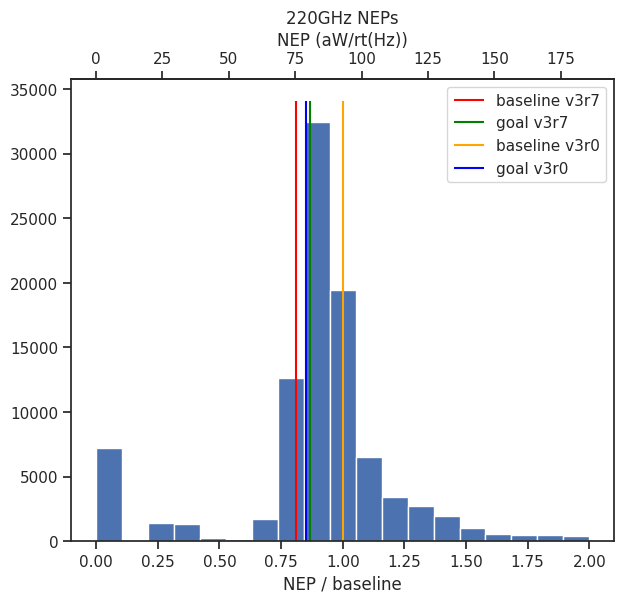

In [145]:
f, ax = plt.subplots(figsize=(7, 6))
flags = np.where(np.char.find(nep_labels, "220") != -1)[0]

baseline_r0 = 92.86
baseline_r7 = 75.43

goal_r0 = 78.89
goal_r7 = 80.56

plt.hist(neps[flags]*1e6/baseline_r0, bins = np.linspace(0,2, 20))
ymax, ymin = ax.get_ylim()
plt.vlines(baseline_r7/baseline_r0, ymin, ymax, label="baseline v3r7", color="red")
plt.vlines(goal_r7/baseline_r0, ymin, ymax, label="goal v3r7", color="green")
plt.vlines(baseline_r0/baseline_r0, ymin, ymax, label="baseline v3r0", color="orange")
plt.vlines(goal_r0/baseline_r0, ymin, ymax, label="goal v3r0", color="blue")
plt.xlabel("NEP / baseline")
plt.title("220GHz NEPs")
plt.legend()

def normalize(x):
    return x / baseline_r0
def denorm(x):
    return x * baseline_r0

secax = ax.secondary_xaxis("top", functions=(denorm, normalize))
secax.set_xlabel("NEP (aW/rt(Hz))")

f.savefig("./plts/nets/neps_220.pdf", dpi=600, bbox_inches='tight')
f.savefig("./plts/nets/neps_220.png", dpi=600, bbox_inches='tight')

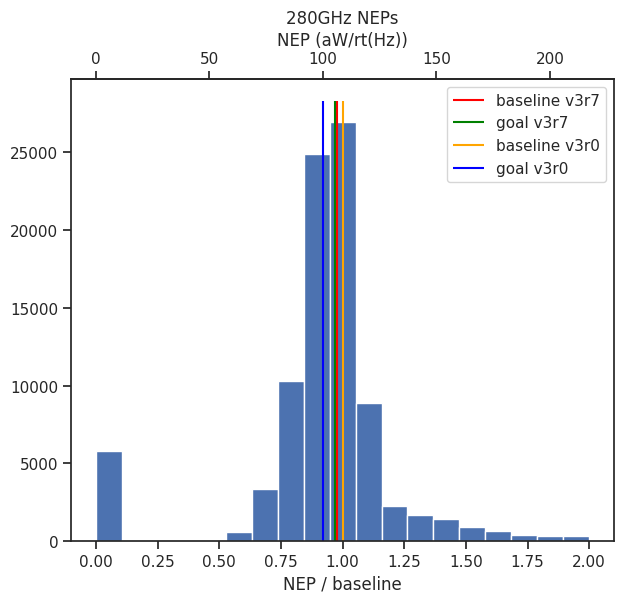

In [147]:
f, ax = plt.subplots(figsize=(7, 6))
flags = np.where(np.char.find(nep_labels, "280") != -1)[0]

baseline_r0 = 108.63
baseline_r7 = 106.37

goal_r0 = 99.79
goal_r7 = 105.25

plt.hist(neps[flags]*1e6/baseline_r0, bins = np.linspace(0,2, 20))
ymax, ymin = ax.get_ylim()
plt.vlines(baseline_r7/baseline_r0, ymin, ymax, label="baseline v3r7", color="red")
plt.vlines(goal_r7/baseline_r0, ymin, ymax, label="goal v3r7", color="green")
plt.vlines(baseline_r0/baseline_r0, ymin, ymax, label="baseline v3r0", color="orange")
plt.vlines(goal_r0/baseline_r0, ymin, ymax, label="goal v3r0", color="blue")
plt.xlabel("NEP / baseline")
plt.title("280GHz NEPs")
plt.legend()

def normalize(x):
    return x / baseline_r0
def denorm(x):
    return x * baseline_r0

secax = ax.secondary_xaxis("top", functions=(denorm, normalize))
secax.set_xlabel("NEP (aW/rt(Hz))")

f.savefig("./plts/nets/neps_280.pdf", dpi=600, bbox_inches='tight')
f.savefig("./plts/nets/neps_280.png", dpi=600, bbox_inches='tight')

# Yield from NEPs

In [164]:
for obs in set(nep_df.obs):
    test = [nep for nep in nep_df.where(nep_df.obs == obs).neps if not np.isnan(nep) and nep > 0]
    print(len(test))

3782
4133
3727
4310
2684
808
3370
3092
4333
3734
2990
2976
2796
1310
3728
1309
501
3829
2789
4435
4361
1489
2957
3771
3283
4327
3208
3943
3839
1774
3022


KeyboardInterrupt: 

In [166]:
len(set(nep_df.obs))

265

### NEP vs PWV

In [172]:
sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
#f, ax = plt.subplots(figsize=(7, 6))

# Add in points to show each observation

mask = df['labels'].str.contains('090_mv14', case=False, na=False)

ymin = 0.95*np.amin(df[mask]["neps"])
ymax = 1.05*np.amax(df[mask]["neps"])


sns.lmplot(
    data=df[mask], x=df[mask].pwv / np.sin(np.deg2rad(df[mask].el)), y="neps"
)

plt.ylim(ymin, ymax)


# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(xlabel="pwv (mm)", ylabel="NEP ($pW / \sqrt{Hz}$)")
sns.despine(trim=True, left=True)

plt.legend()
#f.savefig("./plts/nets/neps_mf.pdf", dpi=600, bbox_inches='tight')
#f.savefig("./plts/nets/neps_mf.png", dpi=600, bbox_inches='tight')

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

# NEIs

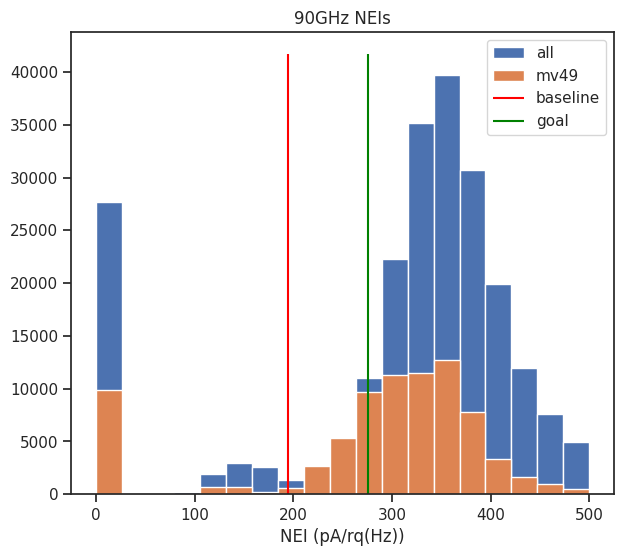

In [9]:
R_BOLO = 0.004 #From bolocalc https://github.com/simonsobs/bolocalc-so-model/blob/848ba3b6f611788b11b782a0a816a802c21fadbe/V3r7/V3r7_Goal/LAT/MF/config/channels.txt
P_SAT_base = 3.42
P_SAT_goal = 1.94 #https://github.com/simonsobs/bolocalc-so-model/blob/848ba3b6f611788b11b782a0a816a802c21fadbe/V3r7/V3r7_Goal/LAT/MF/config/channels.txt
P_OPT_base = 1.04 #https://github.com/simonsobs/bolocalc-so-model/blob/master/V3r7/V3r7_Baseline/LAT/MF/sensitivity.txt
P_OPT_goal = 1.06 

Si_base = 1/np.sqrt(R_BOLO * (P_SAT_base - P_OPT_base))
Si_goal = 1/np.sqrt(R_BOLO * (P_SAT_goal - P_OPT_goal))

f, ax = plt.subplots(figsize=(7, 6))
flags = np.where(np.char.find(nep_labels, "mv49") != -1)[0]
flags_090 = np.where(np.char.find(nep_labels, "090") != -1)[0]

plt.hist(neis[flags_090], bins = np.linspace(0,500, 20), label="all")
plt.hist(neis[flags], bins = np.linspace(0,500, 20), label="mv49")
ymax, ymin = ax.get_ylim()
plt.vlines(18.99*Si_base, ymin, ymax, label="baseline", color="red")
plt.vlines(16.37*Si_goal, ymin, ymax, label="goal", color="green")
plt.xlabel("NEI (pA/rq(Hz))")
plt.title("90GHz NEIs")
plt.legend()

f.savefig("./plts/nets/neis_090.pdf", dpi=600, bbox_inches='tight')
f.savefig("./plts/nets/neis_090.png", dpi=600, bbox_inches='tight')

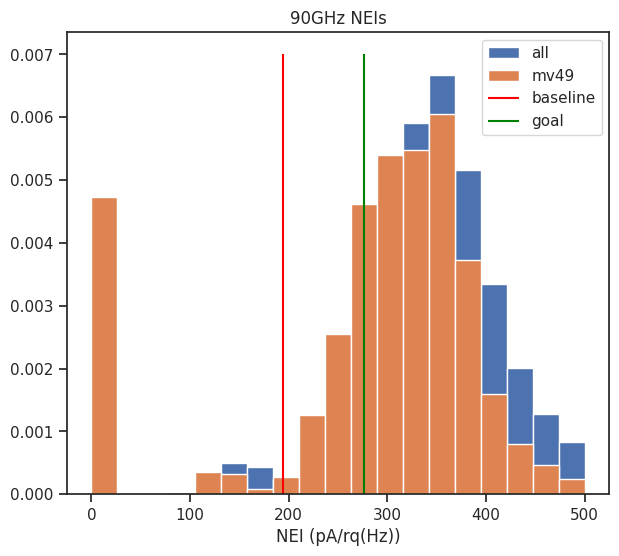

In [19]:
obs_set = np.unique(np.array(obs))


R_BOLO = 0.004 #From bolocalc https://github.com/simonsobs/bolocalc-so-model/blob/848ba3b6f611788b11b782a0a816a802c21fadbe/V3r7/V3r7_Goal/LAT/MF/config/channels.txt
P_SAT_base = 3.42
P_SAT_goal = 1.94 #https://github.com/simonsobs/bolocalc-so-model/blob/848ba3b6f611788b11b782a0a816a802c21fadbe/V3r7/V3r7_Goal/LAT/MF/config/channels.txt
P_OPT_base = 1.04 #https://github.com/simonsobs/bolocalc-so-model/blob/master/V3r7/V3r7_Baseline/LAT/MF/sensitivity.txt
P_OPT_goal = 1.06 

Si_base = 1/np.sqrt(R_BOLO * (P_SAT_base - P_OPT_base))
Si_goal = 1/np.sqrt(R_BOLO * (P_SAT_goal - P_OPT_goal))

f, ax = plt.subplots(figsize=(7, 6))
flags = np.where(np.char.find(nep_labels, "mv49") != -1)[0]
flags_090 = np.where(np.char.find(nep_labels, "090") != -1)[0]
plt.hist(neis[flags_090], bins = np.linspace(0,500, 20), label="all", density=True)
plt.hist(neis[flags], bins = np.linspace(0,500, 20), label="mv49", density=True)


ymax, ymin = ax.get_ylim()
plt.vlines(18.99*Si_base, ymin, ymax, label="baseline", color="red")
plt.vlines(16.37*Si_goal, ymin, ymax, label="goal", color="green")
plt.xlabel("NEI (pA/rq(Hz))")
plt.title("90GHz NEIs")
plt.legend()

f.savefig("./plts/nets/neis_090.pdf", dpi=600, bbox_inches='tight')
f.savefig("./plts/nets/neis_090.png", dpi=600, bbox_inches='tight')


In [42]:
times = np.zeros(len(obs_set))
for i in range(len(times)):
    times[i] = float(obs_set[i][4:14])
    
ys = np.zeros(len(times))
yerr = np.zeros(len(times))
for i in range(len(ys)):
    flags = np.where(np.char.find(obs, str(obs_set[i])) != -1)[0]
    ys[i] = np.nanmean(neis[flags])
    yerr = np.std(neis[flags])
    


<ErrorbarContainer object of 3 artists>

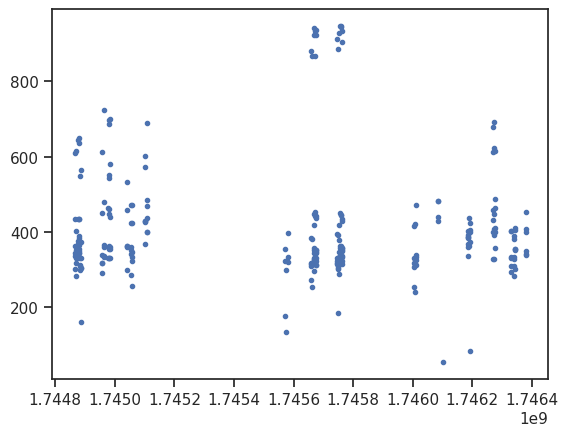

In [50]:
plt.errorbar(times, ys, yerr=np.sqrt(yerr), marker=".", ecolor='k', linestyle='')

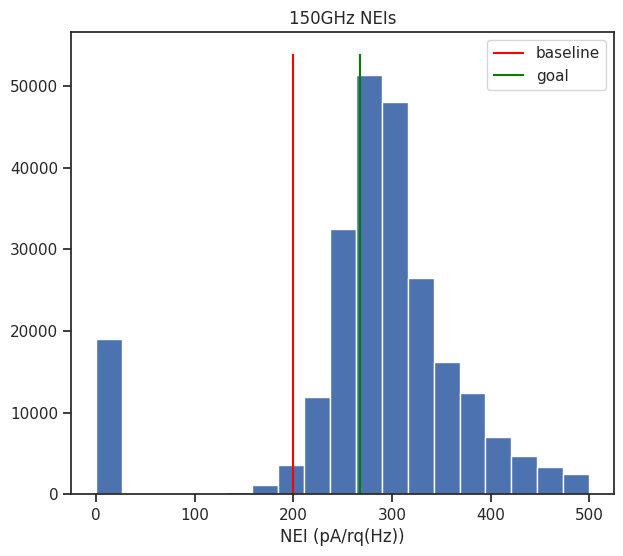

In [9]:
R_BOLO = 0.004 #From bolocalc https://github.com/simonsobs/bolocalc-so-model/blob/848ba3b6f611788b11b782a0a816a802c21fadbe/V3r7/V3r7_Goal/LAT/MF/config/channels.txt
P_SAT_base = 9.37
P_SAT_goal = 5.33 #https://github.com/simonsobs/bolocalc-so-model/blob/848ba3b6f611788b11b782a0a816a802c21fadbe/V3r7/V3r7_Goal/LAT/MF/config/channels.txt
P_OPT_base = 2.23 #https://github.com/simonsobs/bolocalc-so-model/blob/master/V3r7/V3r7_Baseline/LAT/MF/sensitivity.txt
P_OPT_goal = 2.25 

Si_base = 1/np.sqrt(R_BOLO * (P_SAT_base - P_OPT_base))
Si_goal = 1/np.sqrt(R_BOLO * (P_SAT_goal - P_OPT_goal))

f, ax = plt.subplots(figsize=(7, 6))
flags = np.where(np.char.find(nep_labels, "150") != -1)[0]

plt.hist(neis[flags], bins = np.linspace(0,500, 20))
ymax, ymin = ax.get_ylim()
plt.vlines(33.81*Si_base, ymin, ymax, label="baseline", color="red")
plt.vlines(29.72*Si_goal, ymin, ymax, label="goal", color="green")
plt.xlabel("NEI (pA/rq(Hz))")
plt.title("150GHz NEIs")
plt.legend()

f.savefig("./plts/nets/neis_150.pdf", dpi=600, bbox_inches='tight')
f.savefig("./plts/nets/neis_150.png", dpi=600, bbox_inches='tight')

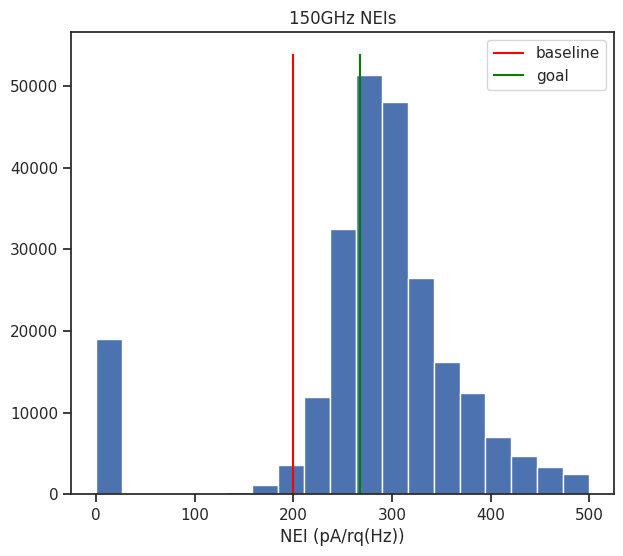

In [10]:
R_BOLO = 0.004 #From bolocalc https://github.com/simonsobs/bolocalc-so-model/blob/848ba3b6f611788b11b782a0a816a802c21fadbe/V3r7/V3r7_Goal/LAT/MF/config/channels.txt
P_SAT_base = 9.37
P_SAT_goal = 5.33 #https://github.com/simonsobs/bolocalc-so-model/blob/848ba3b6f611788b11b782a0a816a802c21fadbe/V3r7/V3r7_Goal/LAT/MF/config/channels.txt
P_OPT_base = 2.23 #https://github.com/simonsobs/bolocalc-so-model/blob/master/V3r7/V3r7_Baseline/LAT/MF/sensitivity.txt
P_OPT_goal = 2.25 

Si_base = 1/np.sqrt(R_BOLO * (P_SAT_base - P_OPT_base))
Si_goal = 1/np.sqrt(R_BOLO * (P_SAT_goal - P_OPT_goal))

f, ax = plt.subplots(figsize=(7, 6))
flags = np.where(np.char.find(nep_labels, "150") != -1)[0]

plt.hist(neis[flags], bins = np.linspace(0,500, 20))
ymax, ymin = ax.get_ylim()
plt.vlines(33.81*Si_base, ymin, ymax, label="baseline", color="red")
plt.vlines(29.72*Si_goal, ymin, ymax, label="goal", color="green")
plt.xlabel("NEI (pA/rq(Hz))")
plt.title("150GHz NEIs")
plt.legend()

f.savefig("./plts/nets/neis_150.pdf", dpi=600, bbox_inches='tight')
f.savefig("./plts/nets/neis_150.png", dpi=600, bbox_inches='tight')

In [43]:
from sotodlib import core

import datetime as dt

import numpy as np
import dill as pk
from numba import prange

from optical_loading import pwv_interp

import glob

import matplotlib.pyplot as plt

results = sorted(glob.glob("results_*.pk"))[-1]

with open(results, "rb") as f:
    result_dict = pk.load(f)
    
with open("abscals.pk", "rb") as f:
    abscal_dict = pk.load(f)

try:
    with open("nets.pk", "rb") as f:
        net_dict = pk.load(f)

except:
    net_dict = {}

    for key in abscal_dict.keys():
        ufm = key.split("_")[0]
        freq = key.split("_")[1]
        if ufm in abscal_dict.keys():
            continue
        if "090" in freq or "150" in freq:
            net_dict[ufm] = {"090":{"chi":[], "obs":[], "ndets":[], "nets":[], "raw_cal":[], "el":[], "pwv":[], "neps":[], "phiconv":[]}, "150":{"chi":[], "obs":[], "ndets":[], "nets":[], "raw_cal":[], "el":[], "pwv":[], "neps":[], "phiconv":[]}}
        else:
            net_dict[ufm] = {"220":{"chi":[], "obs":[], "ndets":[], "nets":[], "raw_cal":[], "el":[], "pwv":[], "neps":[], "phiconv":[]}, "280":{"chi":[], "obs":[], "ndets":[], "nets":[], "raw_cal":[], "el":[], "pwv":[], "neps":[], "phiconv":[]}}
    
ctx = core.Context('./smurf_det_preproc.yaml')
old_ctx = core.Context("./smurf_det_preproc-old-detcal.yaml")

start = dt.datetime(2025,4,17, tzinfo=dt.timezone.utc)
end = dt.datetime(2025,8,21, tzinfo=dt.timezone.utc)
obs_list = ctx.obsdb.query(
    f"{end.timestamp()} > timestamp and timestamp > {start.timestamp()} and type=='obs' and subtype=='cmb'"
)

pwv = pwv_interp()



In [44]:
i = 0
j = 0
ufm_band=1
band = "090"
cur_obs = obs_list[i]
wafers = cur_obs["stream_ids_list"].split(",")
cur_wafer = wafers[j].split("_")[-1]
meta = ctx.get_meta(cur_obs["obs_id"])


In [45]:
old_meta = old_ctx.get_meta(cur_obs["obs_id"])

In [56]:
wafer_flag = np.array([cur_wafer in ufm for ufm in meta.det_info.stream_id])
bp = (meta.det_cal.bg % 4) // 2

if ufm_band == 1:
    net_flag = wafer_flag * (bp==0)
elif ufm_band == 2:
    net_flag = wafer_flag * (bp==1)
raw_cal = np.nanmedian(meta.abscal.raw_abscal_rj[net_flag])
ndets = len(np.where((meta.preprocess.noise.white_noise[net_flag] != 0))[0])

net_mes = 1/np.sqrt(2) * meta.preprocess.noise.white_noise[net_flag] * raw_cal 
clean_nets = []
for net in net_mes:
    if net*1e6 > 0:
        clean_nets.append(net)
clean_nets = np.array(clean_nets)
array_net = np.nansum((clean_nets*1e6)**(-2))**(-1/2)

In [48]:
wafer_flag = np.array([cur_wafer in ufm for ufm in old_meta.det_info.stream_id])
bp = (old_meta.det_cal.bg % 4) // 2

if ufm_band == 1:
    net_flag = wafer_flag * (bp==0)
elif ufm_band == 2:
    net_flag = wafer_flag * (bp==1)
raw_cal = np.nanmedian(old_meta.abscal.raw_abscal_rj[net_flag])
ndets = len(np.where((old_meta.preprocess.noise.white_noise[net_flag] != 0))[0])

net_mes = 1/np.sqrt(2) * old_meta.preprocess.noise.white_noise[net_flag] * raw_cal * old_meta.det_cal.phase_to_pW[net_flag]
clean_nets = []
for net in net_mes:
    if net*1e6 >= 12.5:
        clean_nets.append(net)
clean_nets = np.array(clean_nets)
array_net = np.nansum((clean_nets*1e6)**(-2))**(-1/2)

In [57]:
array_net

np.float64(9.924879714998267)

In [35]:
array_net*10

np.float64(8.763585437252564)

In [13]:
with open("backups/backup_nets.pk", "rb") as f:
    old_nets = pk.load(f)

(array([ 77., 572.,  64.,  23.,   9.,   5.,   3.,   2.,   2.]),
 array([0.00000000e+00, 1.11111111e-06, 2.22222222e-06, 3.33333333e-06,
        4.44444444e-06, 5.55555556e-06, 6.66666667e-06, 7.77777778e-06,
        8.88888889e-06, 1.00000000e-05]),
 <BarContainer object of 9 artists>)

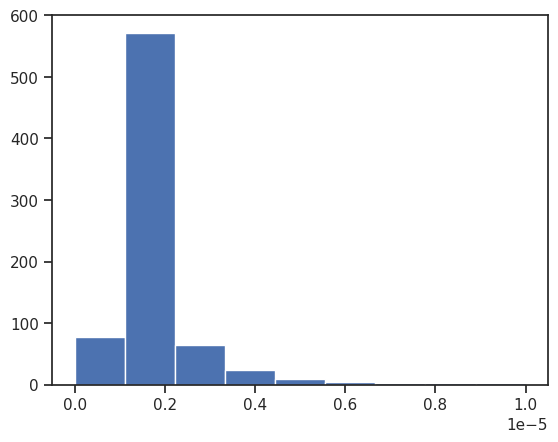

In [18]:
plt.hist(meta.preprocess.noise.white_noise[net_flag] * meta.det_cal.phase_to_pW[net_flag], bins = np.linspace(0,1e-5,10))

(array([ 95., 536., 151.,  24.,  16.,   4.,   5.,   2.,   3.]),
 array([0.00000000e+00, 1.11111111e-05, 2.22222222e-05, 3.33333333e-05,
        4.44444444e-05, 5.55555556e-05, 6.66666667e-05, 7.77777778e-05,
        8.88888889e-05, 1.00000000e-04]),
 <BarContainer object of 9 artists>)

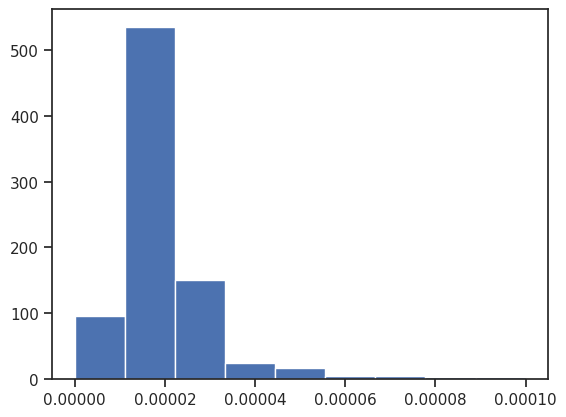

In [21]:
plt.hist(old_nets["mv14"]["090"]["neps"][0], bins = np.linspace(0,1e-4,10))

(array([  0.,  14., 683.,  50.,   5.,   2.,   1.,   3.,   0.]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ]),
 <BarContainer object of 9 artists>)

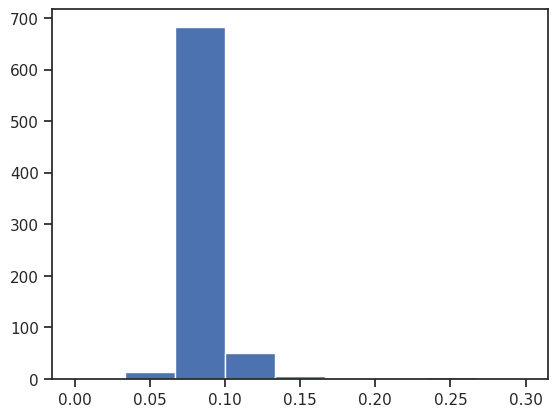

In [27]:
plt.hist(meta.det_cal.phase_to_pW[net_flag], bins=np.linspace(0,0.3,10))

(array([  3.,  33., 790.,  13.,   0.,   0.,   0.,   0.,   0.]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ]),
 <BarContainer object of 9 artists>)

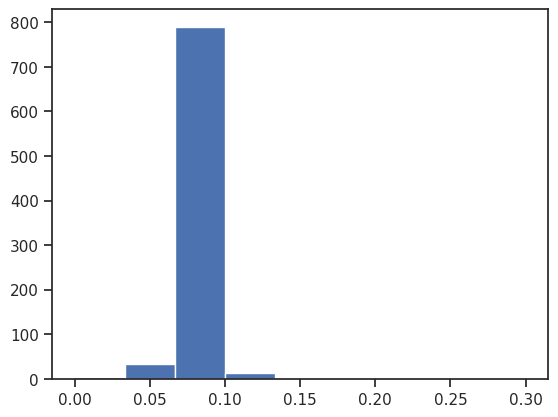

In [28]:
plt.hist(old_nets["mv14"]["090"]["phiconv"][0], bins=np.linspace(0,0.3,10))

(array([ 48.,  12.,  35., 464., 116.,  28.,  12.,  12.,   9.]),
 array([0.00000000e+00, 5.55555556e-06, 1.11111111e-05, 1.66666667e-05,
        2.22222222e-05, 2.77777778e-05, 3.33333333e-05, 3.88888889e-05,
        4.44444444e-05, 5.00000000e-05]),
 <BarContainer object of 9 artists>)

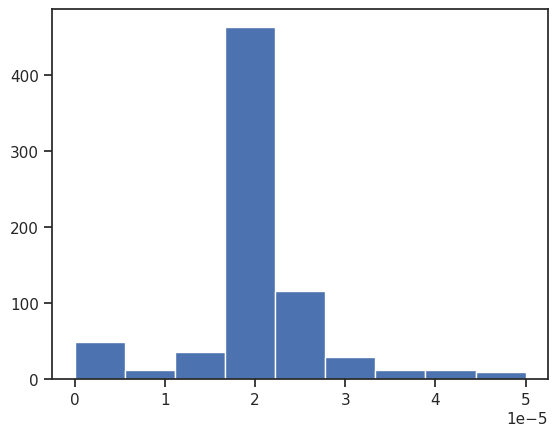

In [30]:
plt.hist(meta.preprocess.noise.white_noise[net_flag], bins=np.linspace(0,5e-5,10))

(array([ 74.,   3.,  25., 143., 378., 122.,  30.,  14.,  11.]),
 array([0.00000000e+00, 5.55555556e-05, 1.11111111e-04, 1.66666667e-04,
        2.22222222e-04, 2.77777778e-04, 3.33333333e-04, 3.88888889e-04,
        4.44444444e-04, 5.00000000e-04]),
 <BarContainer object of 9 artists>)

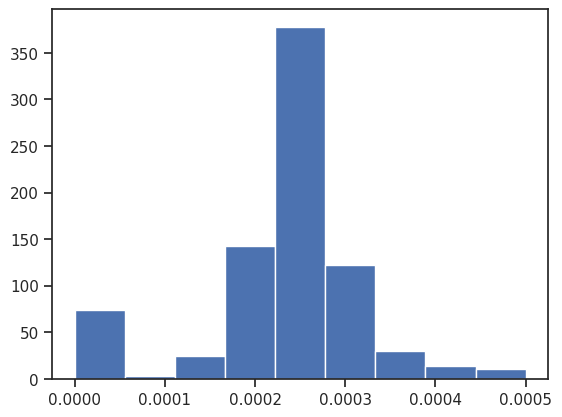

In [32]:
plt.hist(old_nets["mv14"]["090"]["neps"][0]/old_nets["mv14"]["090"]["phiconv"][0], bins=np.linspace(0,5e-4,10))

In [41]:
np.mean(old_meta.preprocess.noise.white_noise[net_flag])

np.float32(2.2028264e-05)

In [42]:
np.nanmean(old_nets["mv14"]["090"]["neps"][0]/old_nets["mv14"]["090"]["phiconv"][0])

np.float64(0.00027342775335511405)